In [1]:
# Install necessary libraries
import json
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from matplotlib.colors import rgb_to_hsv
from scipy import stats

In [2]:
# Mount:
# drive.mount('/content/drive', force_remount = True)

In [3]:
# Read json file
def readJsonData(JSON_FILE_PATH):
  data = None
  try:
    with open(JSON_FILE_PATH, 'r') as f:
        data = json.load(f)
    print("✅ JSON file loaded successfully.")

    metadata = data.get('metadata', {})
    print(f"\n--- Session Metadata ---")
    for key, value in metadata.items():
        print(f"{key.ljust(20)}: {value}")

  except FileNotFoundError:
      print(f"❌ ERROR: File not found at path: {JSON_FILE_PATH}")
      print("Please check the file path and ensure Google Drive is correctly mounted.")
  except json.JSONDecodeError:
      print("❌ ERROR: Could not decode JSON. Ensure the file is valid.")
  return data

# Preprocessing
def preprocessData(data):
  flat_data = []

  # Extract metadata for easy merging later
  session_metadata = data.get('metadata', {})
  session_name = session_metadata.get('sessionName', 'Unknown Session')

  # Iterate through each sample (color card)
  for sample in data.get('data', []):
      sample_number = sample.get('sampleNumber')

      # Iterate through each measurement (1 to 10) within that sample
      for capture_index, measurement in enumerate(sample.get('measurements', [])):

          # Create a dictionary for the current row
          row = {
              'session_name': session_name,
              'sample_number': sample_number,
              'capture_index': capture_index, # 0 to 9
              'lighting_condition': session_metadata.get('lightingCondition'),
              'reflective_surface': session_metadata.get('useReflectiveSurface'),

              # Sensor Data
              'pitch': measurement['angles']['pitch'],
              'roll': measurement['angles']['roll'],
          }

          # Extract Color Data (White and Color reticles, three radii each)

          # White Reticle Captures
          for radius in [0, 2, 4]:
              capture_key = f'r{radius}'
              color_data = measurement['white'].get(capture_key, {'r': 0, 'g': 0, 'b': 0})
              row[f'white_r{radius}_R'] = color_data['r']
              row[f'white_r{radius}_G'] = color_data['g']
              row[f'white_r{radius}_B'] = color_data['b']

          # Color Reticle Captures
          for radius in [0, 2, 4]:
              capture_key = f'r{radius}'
              color_data = measurement['color'].get(capture_key, {'r': 0, 'g': 0, 'b': 0})
              row[f'color_r{radius}_R'] = color_data['r']
              row[f'color_r{radius}_G'] = color_data['g']
              row[f'color_r{radius}_B'] = color_data['b']

          flat_data.append(row)

  # Convert the list of dictionaries to a Pandas DataFrame
  df = pd.DataFrame(flat_data)

  print(f"\n✅ Data flattened into DataFrame with {len(df)} rows (Total captures: 24 samples * 10 captures = 240 rows).")
  return df

# ## 3. Initial Review and Visualization

# Display the first few rows and the column types for verification.
def displayDataFrameInfo(df):
  print("\n--- DataFrame Head (First 5 Rows) ---")
  print(df.head())

  print("\n--- DataFrame Information ---")
  print(df.info())

  # ### 3.1 Check Sensor Variability

  # This checks the pitch/roll stability across all 240 measurements.
  print("\n--- Sensor Angle Statistics ---")
  print(df[['pitch', 'roll']].describe())

In [4]:
def correctByScaling(ref_r, ref_g, ref_b, meas_r, meas_g, meas_b, RefOption = 'white'):
  if RefOption == 'white':
    scale_r = 255.0 / (ref_r if ref_r > 0 else 1.0)
    scale_g = 255.0 / (ref_g if ref_g > 0 else 1.0)
    scale_b = 255.0 / (ref_b if ref_b > 0 else 1.0)

    corr_r = np.clip(meas_r * scale_r, 0, 255).astype(int)
    corr_g = np.clip(meas_g * scale_g, 0, 255).astype(int)
    corr_b = np.clip(meas_b * scale_b, 0, 255).astype(int)

  elif RefOption == 'black':
    scale_factor = 255.0 / 50.0

    corr_r = np.clip(meas_r * scale_factor, 0, 255).astype(int)
    corr_g = np.clip(meas_g * scale_factor, 0, 255).astype(int)
    corr_b = np.clip(meas_b * scale_factor, 0, 255).astype(int)

  return corr_r, corr_g, corr_b

def apply_correction(row, color_prefix = 'white_r', radius = 4, correctionFunction = correctByScaling):
    # Get raw white reference (R4)
    ref_r = row['white_r' + str(radius) + '_R']
    ref_g = row['white_r' + str(radius) + '_G']
    ref_b = row['white_r' + str(radius) + '_B']

    # Get raw measured color (R4)
    meas_r = row[f'{color_prefix}_R']
    meas_g = row[f'{color_prefix}_G']
    meas_b = row[f'{color_prefix}_B']

    # Apply the correction function
    corr_factor_r, corr_factor_g, corr_factor_b = correctionFunction(ref_r, ref_g, ref_b, meas_r, meas_g, meas_b)

    return pd.Series([corr_factor_r, corr_factor_g, corr_factor_b])

# Apply correction to the color R4 measurements using correctByScaling
def correctRGB(df, correctionFunction = correctByScaling):
  df[['correction_r0_R', 'correction_r0_G', 'correction_r0_B']] = df.apply(
      lambda row: apply_correction(row, 'color_r0', radius = 0, correctionFunction=correctionFunction), axis=1
  )
  df[['correction_r2_R', 'correction_r2_G', 'correction_r2_B']] = df.apply(
      lambda row: apply_correction(row, 'color_r2', radius = 2, correctionFunction=correctionFunction), axis=1
  )
  df[['correction_r4_R', 'correction_r4_G', 'correction_r4_B']] = df.apply(
      lambda row: apply_correction(row, 'color_r4', radius = 4, correctionFunction=correctionFunction), axis=1
  )

  # print( df[['correction_r0_R', 'correction_r0_G', 'correction_r0_B']].describe())
  # print( df[['correction_r2_R', 'correction_r2_G', 'correction_r2_B']].describe())
  # print( df[['correction_r4_R', 'correction_r4_G', 'correction_r4_B']].describe())

In [5]:
def rgb_to_hsv_overload(r, g, b):
    # Normalize R, G, B values to the range 0-1
    r_norm, g_norm, b_norm = map(lambda x: x/255, (r,g,b))

    # Calculate C_max, C_min, and delta
    C_max, C_min = max(r_norm, g_norm, b_norm), min(r_norm, g_norm, b_norm)
    delta = C_max - C_min

    # Calculate Hue (H)
    h = 0
    if delta > 0:
      if C_max == r_norm: h = 60 * (((g_norm - b_norm) / delta) % 6)
      elif C_max == g_norm: h = 60 * (((b_norm - r_norm) / delta) + 2)
      elif C_max == b_norm: h = 60 * (((r_norm - g_norm) / delta) + 4)

    # Ensure H is in the range [0, 360)
    if h < 0: h += 360

    # Calculate Saturation (S)
    s = delta / C_max if C_max > 0 else 0

    # Calculate Value (V)
    v = C_max

    return h, s, v

def rgb_to_hex(r, g, b):
    return '#{:02x}{:02x}{:02x}'.format(int(r), int(g), int(b))

In [6]:
def combineGroundTruth(df):
  ground_truth_data = [
      {'sample_number': 1,  'label': 'Dark Skin',      'gt__R': 115, 'gt__G': 82,  'gt__B': 69},
      {'sample_number': 2,  'label': 'Light Skin',     'gt__R': 204, 'gt__G': 161, 'gt__B': 141},
      {'sample_number': 3,  'label': 'Blue Sky',       'gt__R': 101, 'gt__G': 134, 'gt__B': 179},
      {'sample_number': 4,  'label': 'Foliage',        'gt__R': 89,  'gt__G': 109, 'gt__B': 61},
      {'sample_number': 5,  'label': 'Blue Flower',    'gt__R': 141, 'gt__G': 137, 'gt__B': 194},
      {'sample_number': 6,  'label': 'Bluish Green',   'gt__R': 132, 'gt__G': 228, 'gt__B': 208},
      {'sample_number': 7,  'label': 'Orange',         'gt__R': 249, 'gt__G': 118, 'gt__B': 35},
      {'sample_number': 8,  'label': 'Purplish Blue',  'gt__R': 80,  'gt__G': 91,  'gt__B': 182},
      {'sample_number': 9,  'label': 'Moderate Red',   'gt__R': 222, 'gt__G': 91,  'gt__B': 125},
      {'sample_number': 10, 'label': 'Purple',         'gt__R': 91,  'gt__G': 63,  'gt__B': 123},
      {'sample_number': 11, 'label': 'Yellow Green',   'gt__R': 173, 'gt__G': 232, 'gt__B': 91},
      {'sample_number': 12, 'label': 'Orange Yellow',  'gt__R': 255, 'gt__G': 164, 'gt__B': 26},
      {'sample_number': 13, 'label': 'Blue',           'gt__R': 44,  'gt__G': 56,  'gt__B': 142},
      {'sample_number': 14, 'label': 'Green',          'gt__R': 74,  'gt__G': 148, 'gt__B': 81},
      {'sample_number': 15, 'label': 'Red',            'gt__R': 179, 'gt__G': 42,  'gt__B': 50},
      {'sample_number': 16, 'label': 'Yellow',         'gt__R': 250, 'gt__G': 226, 'gt__B': 21},
      {'sample_number': 17, 'label': 'Magenta',        'gt__R': 191, 'gt__G': 81,  'gt__B': 160},
      {'sample_number': 18, 'label': 'Cyan',           'gt__R': 6,   'gt__G': 142, 'gt__B': 172},
      {'sample_number': 19, 'label': 'White',          'gt__R': 252, 'gt__G': 252, 'gt__B': 252},
      {'sample_number': 20, 'label': 'Neutral 8',      'gt__R': 230, 'gt__G': 230, 'gt__B': 230},
      {'sample_number': 21, 'label': 'Neutral 6.5',    'gt__R': 200, 'gt__G': 200, 'gt__B': 200},
      {'sample_number': 22, 'label': 'Neutral 5',      'gt__R': 143, 'gt__G': 143, 'gt__B': 142},
      {'sample_number': 23, 'label': 'Neutral 3.5',    'gt__R': 100, 'gt__G': 100, 'gt__B': 100},
      {'sample_number': 24, 'label': 'Black',          'gt__R': 50,  'gt__G': 50,  'gt__B': 50},
  ]
  df_gt = pd.DataFrame(ground_truth_data)
  df = pd.merge(df, df_gt, on='sample_number', how='outer')

  return df, df_gt

def generateFinalDataFrame(df_with_gt_columns):
  # Calculate average color and corrected color values per sample_number
  avg_cols_to_compute = [
      'color_r0_R', 'color_r0_G', 'color_r0_B',
      'correction_r0_R', 'correction_r0_G', 'correction_r0_B',
      'color_r2_R', 'color_r2_G', 'color_r2_B',
      'correction_r2_R', 'correction_r2_G', 'correction_r2_B',
      'color_r4_R', 'color_r4_G', 'color_r4_B',
      'correction_r4_R', 'correction_r4_G', 'correction_r4_B'
  ]
  df_avg = df_with_gt_columns.groupby('sample_number')[avg_cols_to_compute].mean().reset_index()

  # Rename columns to 'avg_...' to clearly distinguish them
  new_avg_columns_map = {col: 'avg_' + col for col in avg_cols_to_compute}
  df_avg = df_avg.rename(columns=new_avg_columns_map)

  # Merge the df (which now has ground truth) with the averaged color data
  df_final_comparison = pd.merge(df_with_gt_columns, df_avg, on='sample_number', how='left')

  return df_final_comparison

In [7]:
def pipeline(jsonFilePath, radius_choice='r4', correction_method_name=correctByScaling, output_color_space='RGB'):
  data = readJsonData(jsonFilePath)
  df = preprocessData(data)
  correctRGB(df, correction_method_name)
  df, _ = combineGroundTruth(df)

  # Convert original RGB values to HSV and add to DataFrame
  rgb_column_sets = [
      ('white', 'r0'), ('white', 'r2'), ('white', 'r4'),
      ('color', 'r0'), ('color', 'r2'), ('color', 'r4'),
      ('gt', '') # This entry needs to be fixed to match the new gt__R naming
  ]

  for prefix, radius in rgb_column_sets:
      # Special handling for ground truth to match the double underscore naming
      if prefix == 'gt':
          r_col, g_col, b_col = 'gt__R', 'gt__G', 'gt__B'
          h_col, s_col, v_col = 'gt__H', 'gt__S', 'gt__V'
      else:
          r_col, g_col, b_col = f'{prefix}_{radius}_R', f'{prefix}_{radius}_G', f'{prefix}_{radius}_B'
          h_col, s_col, v_col = f'{prefix}_{radius}_H', f'{prefix}_{radius}_S', f'{prefix}_{radius}_V'

      df[[h_col, s_col, v_col]] = df.apply(
          lambda row: rgb_to_hsv_overload(row[r_col], row[g_col], row[b_col]),
          axis=1, result_type='expand'
      )
  displayDataFrameInfo(df)
  return df

In [8]:
def plot_comparison_grid(df_final_comparison, radius, rows=6, cols=4):
    # To ensure one plot per sample, we'll take unique sample_numbers and the first associated row
    # The 'avg_' and 'gt__' columns should be constant for all rows of a given sample_number after the new merge logic
    df_plot = df_final_comparison.drop_duplicates(subset=['sample_number']).reset_index(drop=True)

    num_samples = len(df_plot)
    print(f"Plotting {num_samples} unique samples for radius r{radius}.")

    if num_samples == 0:
        print(f"No data to plot for radius r{radius}.")
        return

    if num_samples != rows * cols:
        print(f"Warning: Number of samples ({num_samples}) does not match grid size ({rows}x{cols}). Plotting up to {rows * cols} samples.")

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
    axes = axes.flatten()

    for i, row_data in df_plot.iterrows():
        if i >= len(axes):
            break # Stop if we run out of subplots

        # Dynamically extract columns based on radius, now using the 'avg_' prefix for comparison plots
        uncorr_r, uncorr_g, uncorr_b = row_data[f'avg_color_r{radius}_R'], row_data[f'avg_color_r{radius}_G'], row_data[f'avg_color_r{radius}_B']
        corr_r, corr_g, corr_b = row_data[f'avg_correction_r{radius}_R'], row_data[f'avg_correction_r{radius}_G'], row_data[f'avg_correction_r{radius}_B']

        # Ground Truth remains the same
        gt_r, gt_g, gt_b = row_data['gt__R'], row_data['gt__G'], row_data['gt__B']
        label = row_data['label']
        sample_number = row_data['sample_number']

        # Normalize RGB values to 0-1 for imshow
        gt_color_norm = np.array([gt_r, gt_g, gt_b]) / 255.0
        uncorr_color_norm = np.array([uncorr_r, uncorr_g, uncorr_b]) / 255.0
        corr_color_norm = np.array([corr_r, corr_g, corr_b]) / 255.0

        # Create the 100x100 image array for the 3-part comparison
        image = np.zeros((100, 100, 3))

        # Lower half (Ground Truth)
        image[50:100, 0:100] = gt_color_norm
        # Upper-left quarter (Uncorrected)
        image[0:50, 0:50] = uncorr_color_norm
        # Upper-right quarter (Corrected)
        image[0:50, 50:100] = corr_color_norm

        ax = axes[i]
        ax.imshow(image)

        # Add hex labels
        ax.text(25, 75, rgb_to_hex(gt_r, gt_g, gt_b), color='black' if np.mean(gt_color_norm) > 0.5 else 'white',
                ha='center', va='center', fontsize=7, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
        ax.text(25, 25, rgb_to_hex(uncorr_r, uncorr_g, uncorr_b), color='black' if np.mean(uncorr_color_norm) > 0.5 else 'white',
                ha='center', va='center', fontsize=7, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
        ax.text(75, 25, rgb_to_hex(corr_r, corr_g, corr_b), color='black' if np.mean(corr_color_norm) > 0.5 else 'white',
                ha='center', va='center', fontsize=7, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

        ax.set_title(f"#{int(sample_number)}: {label}", fontsize=9)
        ax.set_xticks([])
        ax.set_yticks([])

    # Hide any unused subplots
    for j in range(num_samples, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle(f'R{radius} Comparison (Averaged): Ground Truth vs. Uncorrected vs. Corrected', y=0.98, fontsize=16)
    plt.show()

def plotAllRadius(df_final_comparison):
  for radius in [0, 2, 4]:
    plot_comparison_grid(df_final_comparison, radius)

In [9]:
def plot_error_dist(df, r=2):
    fig, axs = plt.subplots(6, 4, figsize=(8, 10), sharey='all')
    for sample_idx in range(0, 24):
        sample_num = sample_idx + 1
        subset = df[df['sample_number'] == sample_num]
        ax = axs[sample_idx//4, sample_idx%4]
        # sns.violinplot(
        #     data = subset[[f'error_r{r}_R', f'error_r{r}_G', f'error_r{r}_B']],
        #     palette = ['red', 'green', 'blue'],
        #     inner=None,
        #     ax=ax
        # )
        sns.swarmplot(
            data = subset[[f'correction_r{r}_R', f'correction_r{r}_G', f'correction_r{r}_B']],
            palette=['red', 'green', 'blue'],
            size=2,
            alpha=0.5,
            ax=ax,
        )
        gt_R = subset['gt__R'].values[0]
        gt_G = subset['gt__G'].values[0]
        gt_B = subset['gt__B'].values[0]
        width = 0.5
        center_R = 0
        center_G = 1
        center_B = 2
        ax.hlines(gt_R, xmin=center_R - width/2, xmax=center_R + width/2, colors='red', linestyles='dashed')
        ax.hlines(gt_G, xmin=center_G - width/2, xmax=center_G + width/2, colors='green', linestyles='dashed')
        ax.hlines(gt_B, xmin=center_B - width/2, xmax=center_B + width/2, colors='blue', linestyles='dashed')
        ax.set_title(
            f'Color {sample_num}',
            color=(gt_R/255, gt_G/255, gt_B/255),
            bbox=dict(facecolor='black')
        )
        ax.set_xticks([])
        ax.set_ylim(0, 256)
    #session_name = df['session_name'].values[0]
    #fig.suptitle(f'session = {session_name}, r = {r}')
    fig.supylabel('corrected RGB - true RGB')
    fig.tight_layout()
    return fig, axs

In [10]:
def convert_rgb_to_hsv(r, g, b):
    # Normalize RGB values to 0-1 range
    normalized_rgb = np.array([r, g, b]) / 255.0
    # Convert to HSV
    hsv = rgb_to_hsv(normalized_rgb)
    return hsv[0], hsv[1], hsv[2]

# Apply to Ground Truth colors
def df_HSV(df_final_comparison):
  df_final_comparison[['gt__H', 'gt__S', 'gt__V']] = df_final_comparison.apply(
      lambda row: convert_rgb_to_hsv(row['gt__R'], row['gt__G'], row['gt__B']),
      axis=1,
      result_type='expand'
  )

  # Apply to Uncorrected colors
  df_final_comparison[['uncorr_H', 'uncorr_S', 'uncorr_V']] = df_final_comparison.apply(
      lambda row: convert_rgb_to_hsv(row['color_r2_R'], row['color_r2_G'], row['color_r2_B']),
      axis=1,
      result_type='expand'
  )

  # Apply to Corrected colors
  df_final_comparison[['corr_H', 'corr_S', 'corr_V']] = df_final_comparison.apply(
      lambda row: convert_rgb_to_hsv(row['correction_r2_R'], row['correction_r2_G'], row['correction_r2_B']),
      axis=1,
      result_type='expand'
  )

  df_final_comparison['H_error_uncorr'] = df_final_comparison['uncorr_H'] - df_final_comparison['gt__H']
  df_final_comparison['H_error_corr'] = df_final_comparison['corr_H'] - df_final_comparison['gt__H']

  df_final_comparison['S_error_uncorr'] = df_final_comparison['uncorr_S'] - df_final_comparison['gt__S']
  df_final_comparison['S_error_corr'] = df_final_comparison['corr_S'] - df_final_comparison['gt__S']

  df_final_comparison['V_error_uncorr'] = df_final_comparison['uncorr_V'] - df_final_comparison['gt__V']
  df_final_comparison['V_error_corr'] = df_final_comparison['corr_V'] - df_final_comparison['gt__V']
  return df_final_comparison

In [11]:
# Define the HSV components to plot
def plotHSV(df_final_comparison):
  hsv_components = ['H', 'S', 'V']

  for component in hsv_components:
      plt.figure(figsize=(10, 6))

      # Uncorrected error column name
      uncorr_error_col = f'{component}_error_uncorr'
      # Corrected error column name
      corr_error_col = f'{component}_error_corr'

      # Plot uncorrected error distribution
      sns.kdeplot(x=df_final_comparison[uncorr_error_col],
              fill=True,
              color='blue',
              label='Uncorrected',
              alpha=0.2,
              common_norm=False)

      # Plot corrected error distribution
      #sns.histplot(df_final_comparison[corr_error_col], kde=True, color='red', label='Corrected', alpha=0.6, stat='density', common_norm=False)

      sns.kdeplot(x=df_final_comparison[corr_error_col],
              fill=True,
              color='red',
              label='Corrected',
              alpha=0.2,
              common_norm=False)

      # Calculate mean and standard deviation for both distributions
      mean_uncorr = df_final_comparison[uncorr_error_col].mean()
      std_uncorr = df_final_comparison[uncorr_error_col].std()

      mean_corr = df_final_comparison[corr_error_col].mean()
      std_corr = df_final_comparison[corr_error_col].std()

      # Add text annotations for mean and std dev
      plt.axvline(mean_uncorr, color='blue', linestyle='dashed', linewidth=1)
      plt.text(mean_uncorr + 0.01, plt.ylim()[1]*0.9, f'Mean Uncorr: {mean_uncorr:.3f}', color='blue', fontsize=10)
      plt.text(mean_uncorr + 0.01, plt.ylim()[1]*0.85, f'Std Uncorr: {std_uncorr:.3f}', color='blue', fontsize=10)

      plt.axvline(mean_corr, color='red', linestyle='dashed', linewidth=1)
      plt.text(mean_corr + 0.01, plt.ylim()[1]*0.75, f'Mean Corr: {mean_corr:.3f}', color='red', fontsize=10)
      plt.text(mean_corr + 0.01, plt.ylim()[1]*0.7, f'Std Corr: {std_corr:.3f}', color='red', fontsize=10)

      # Set title and labels
      plt.title(f'Distribution of {component} Error: Uncorrected vs. Corrected')
      plt.xlabel('Error Value')
      plt.ylabel('Density')
      plt.legend()
      plt.grid(True, linestyle='--', alpha=0.7)
      plt.tight_layout()
      plt.show()


Processing single file: Data/ambient_green.json
✅ JSON file loaded successfully.

--- Session Metadata ---
sessionName         : ambient_green
lightingCondition   : 11
useReflectiveSurface: False
dateTime            : 2025-12-02T22:34:41.738357

✅ Data flattened into DataFrame with 240 rows (Total captures: 24 samples * 10 captures = 240 rows).

--- DataFrame Head (First 5 Rows) ---
    session_name  sample_number  capture_index  lighting_condition  \
0  ambient_green              1              0                  11   
1  ambient_green              1              1                  11   
2  ambient_green              1              2                  11   
3  ambient_green              1              3                  11   
4  ambient_green              1              4                  11   

   reflective_surface     pitch      roll  white_r0_R  white_r0_G  white_r0_B  \
0               False  4.340647  1.544648           1         127          43   
1               False  4.113008

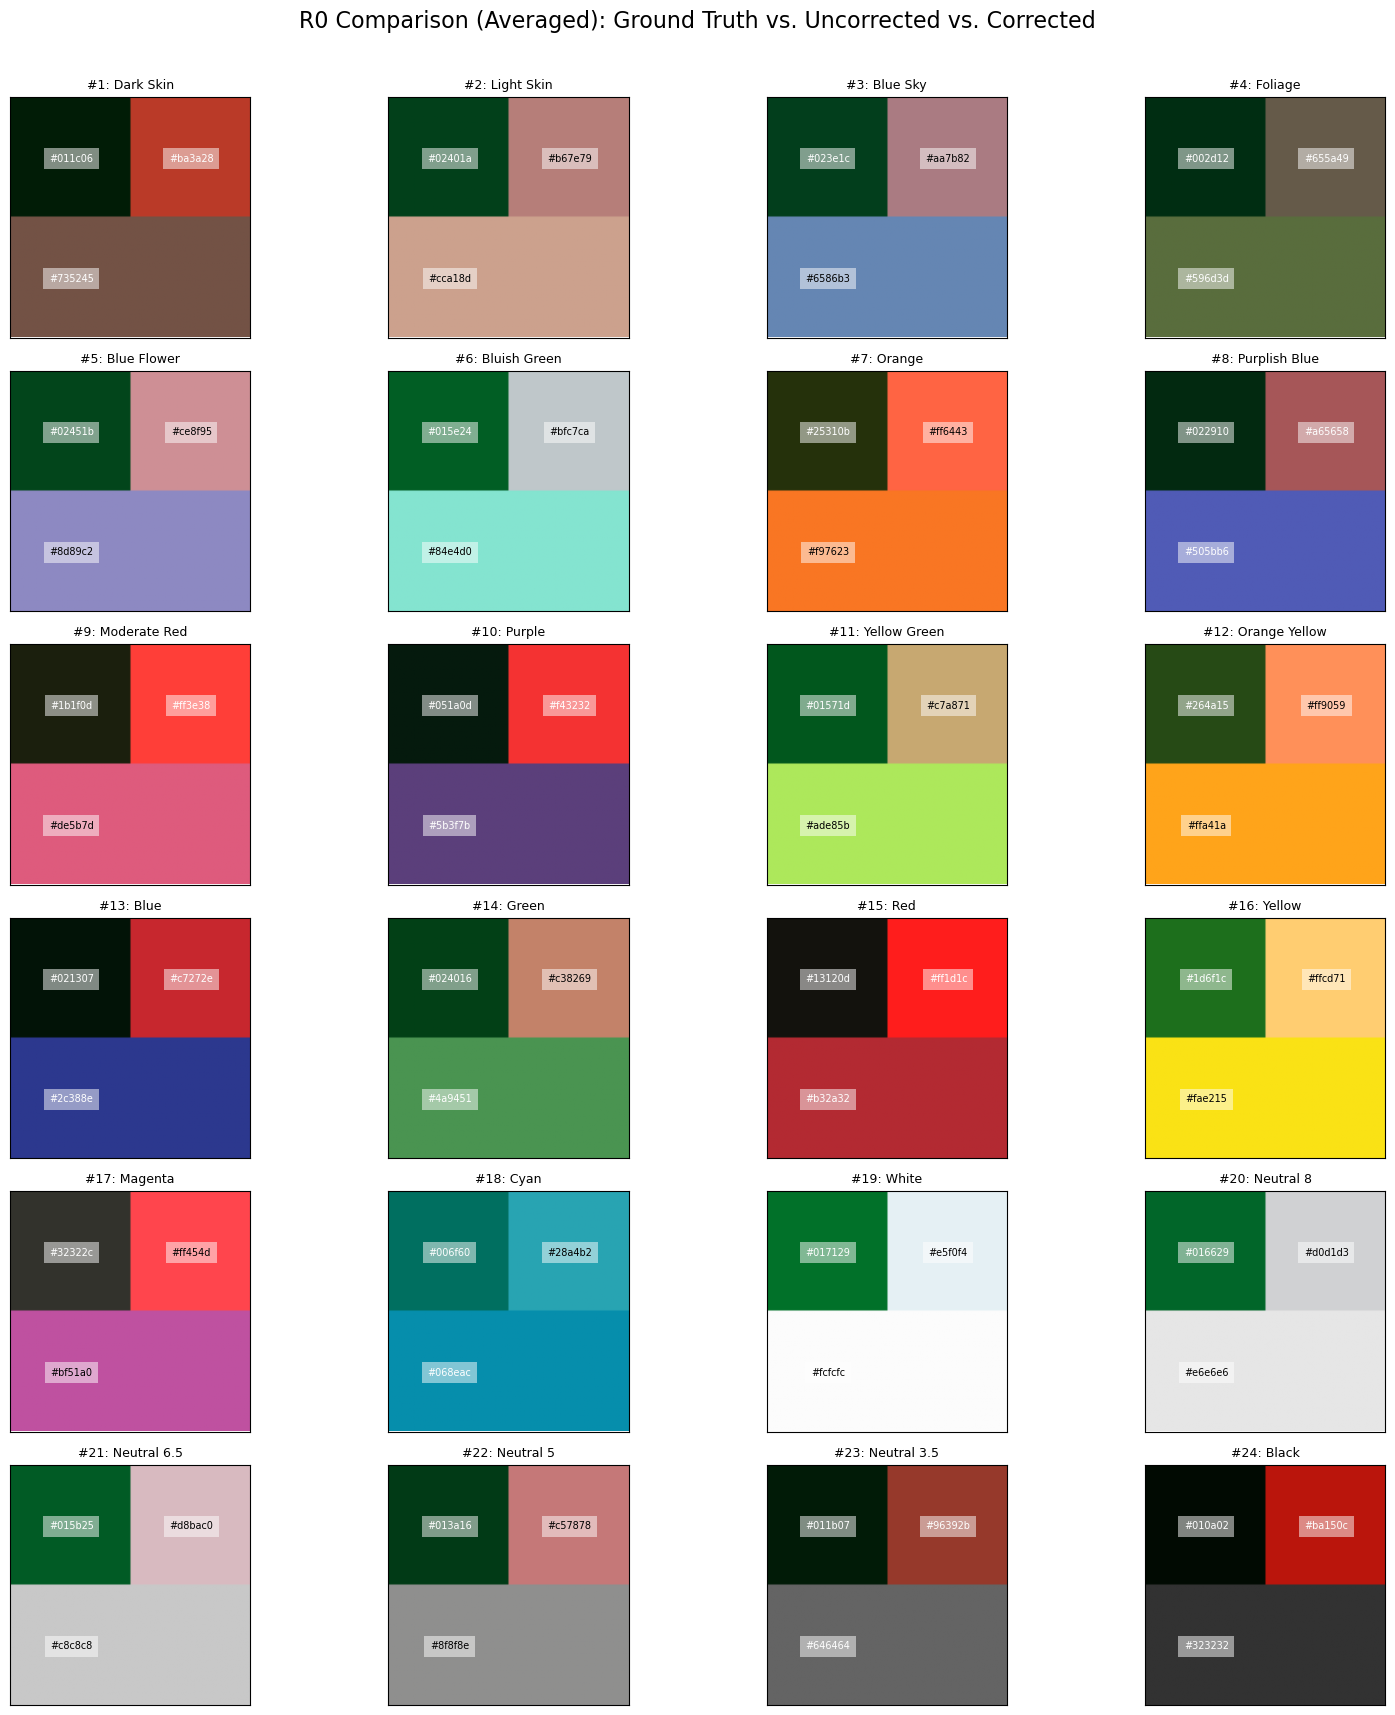

Plotting 24 unique samples for radius r2.


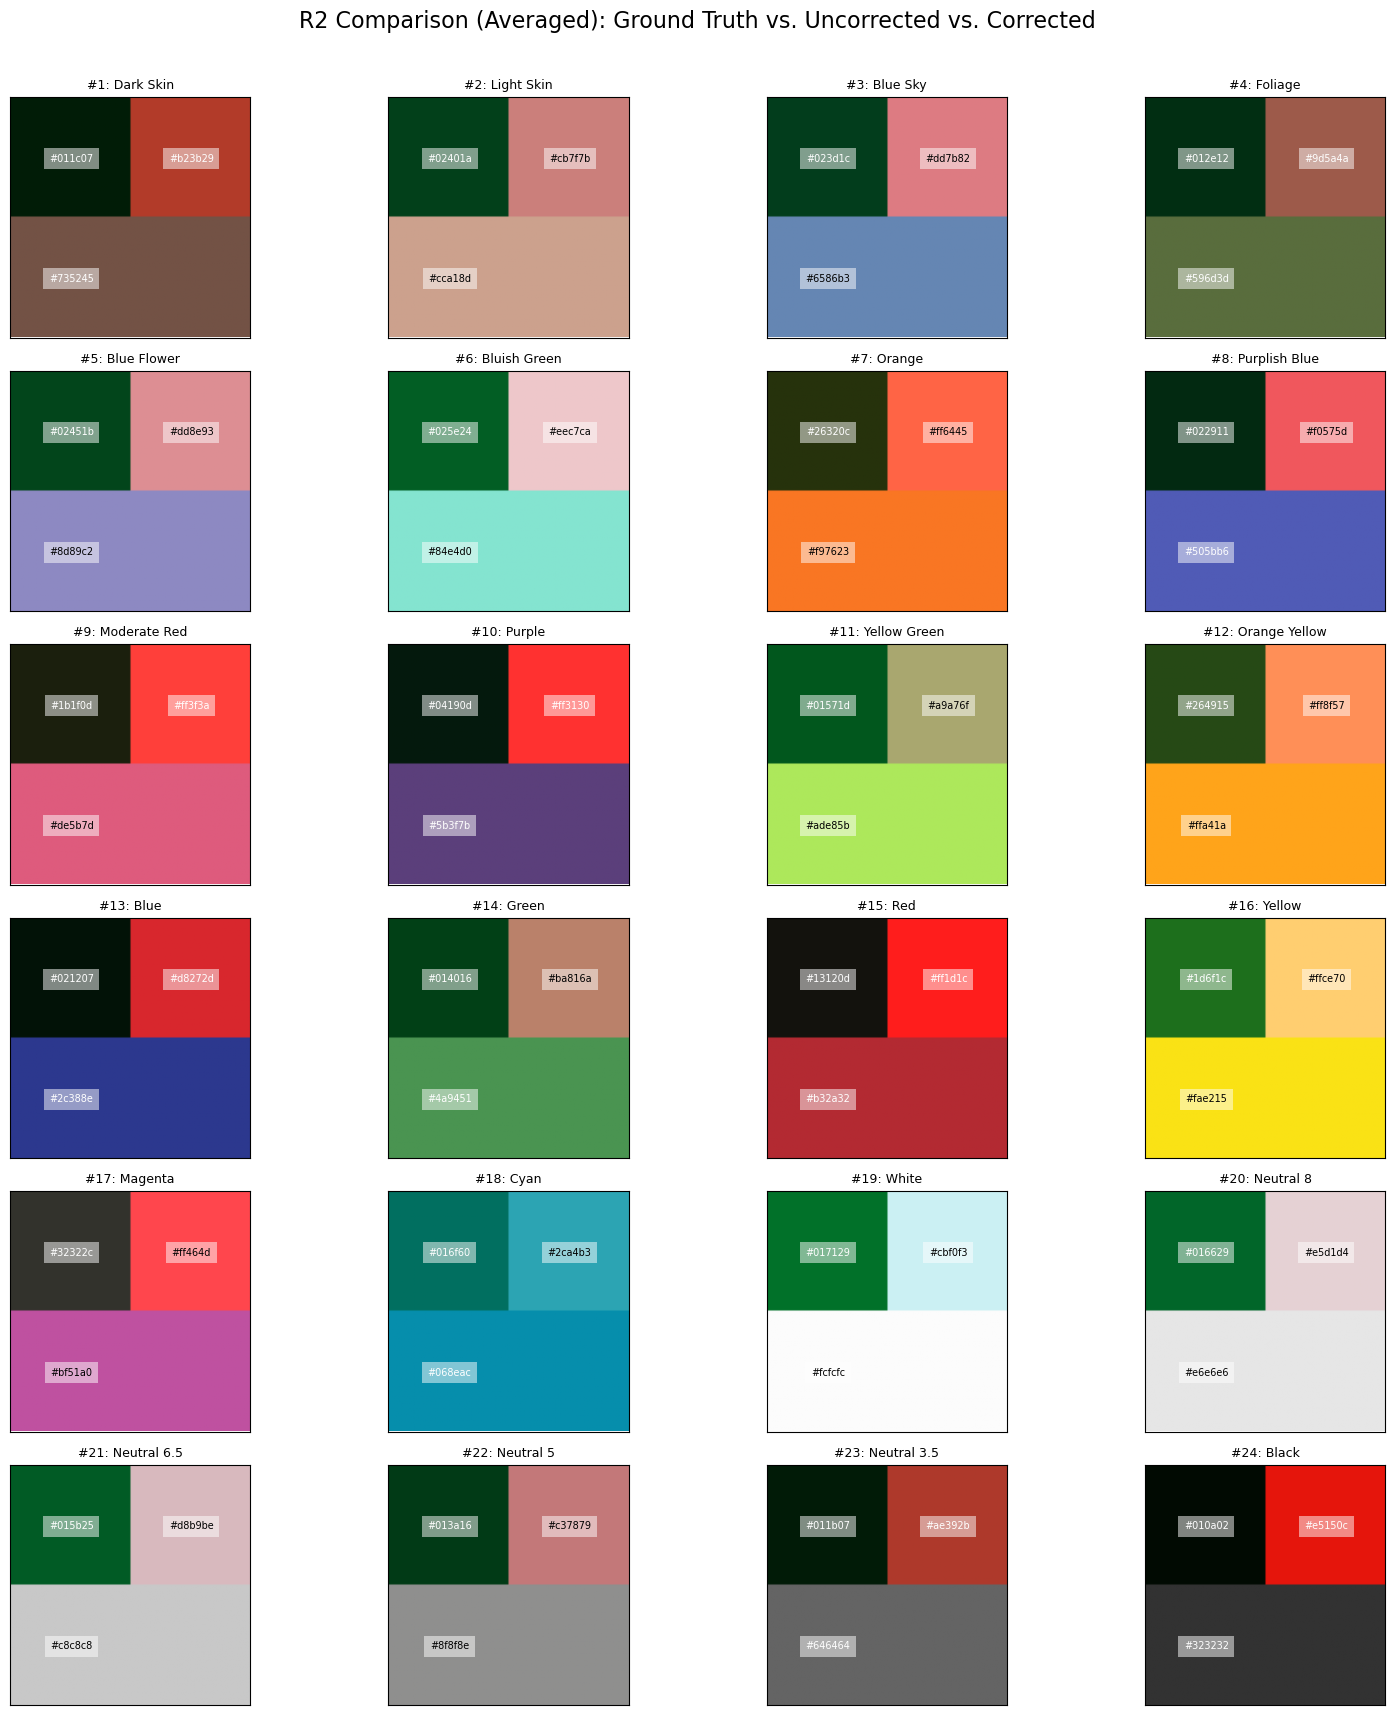

Plotting 24 unique samples for radius r4.


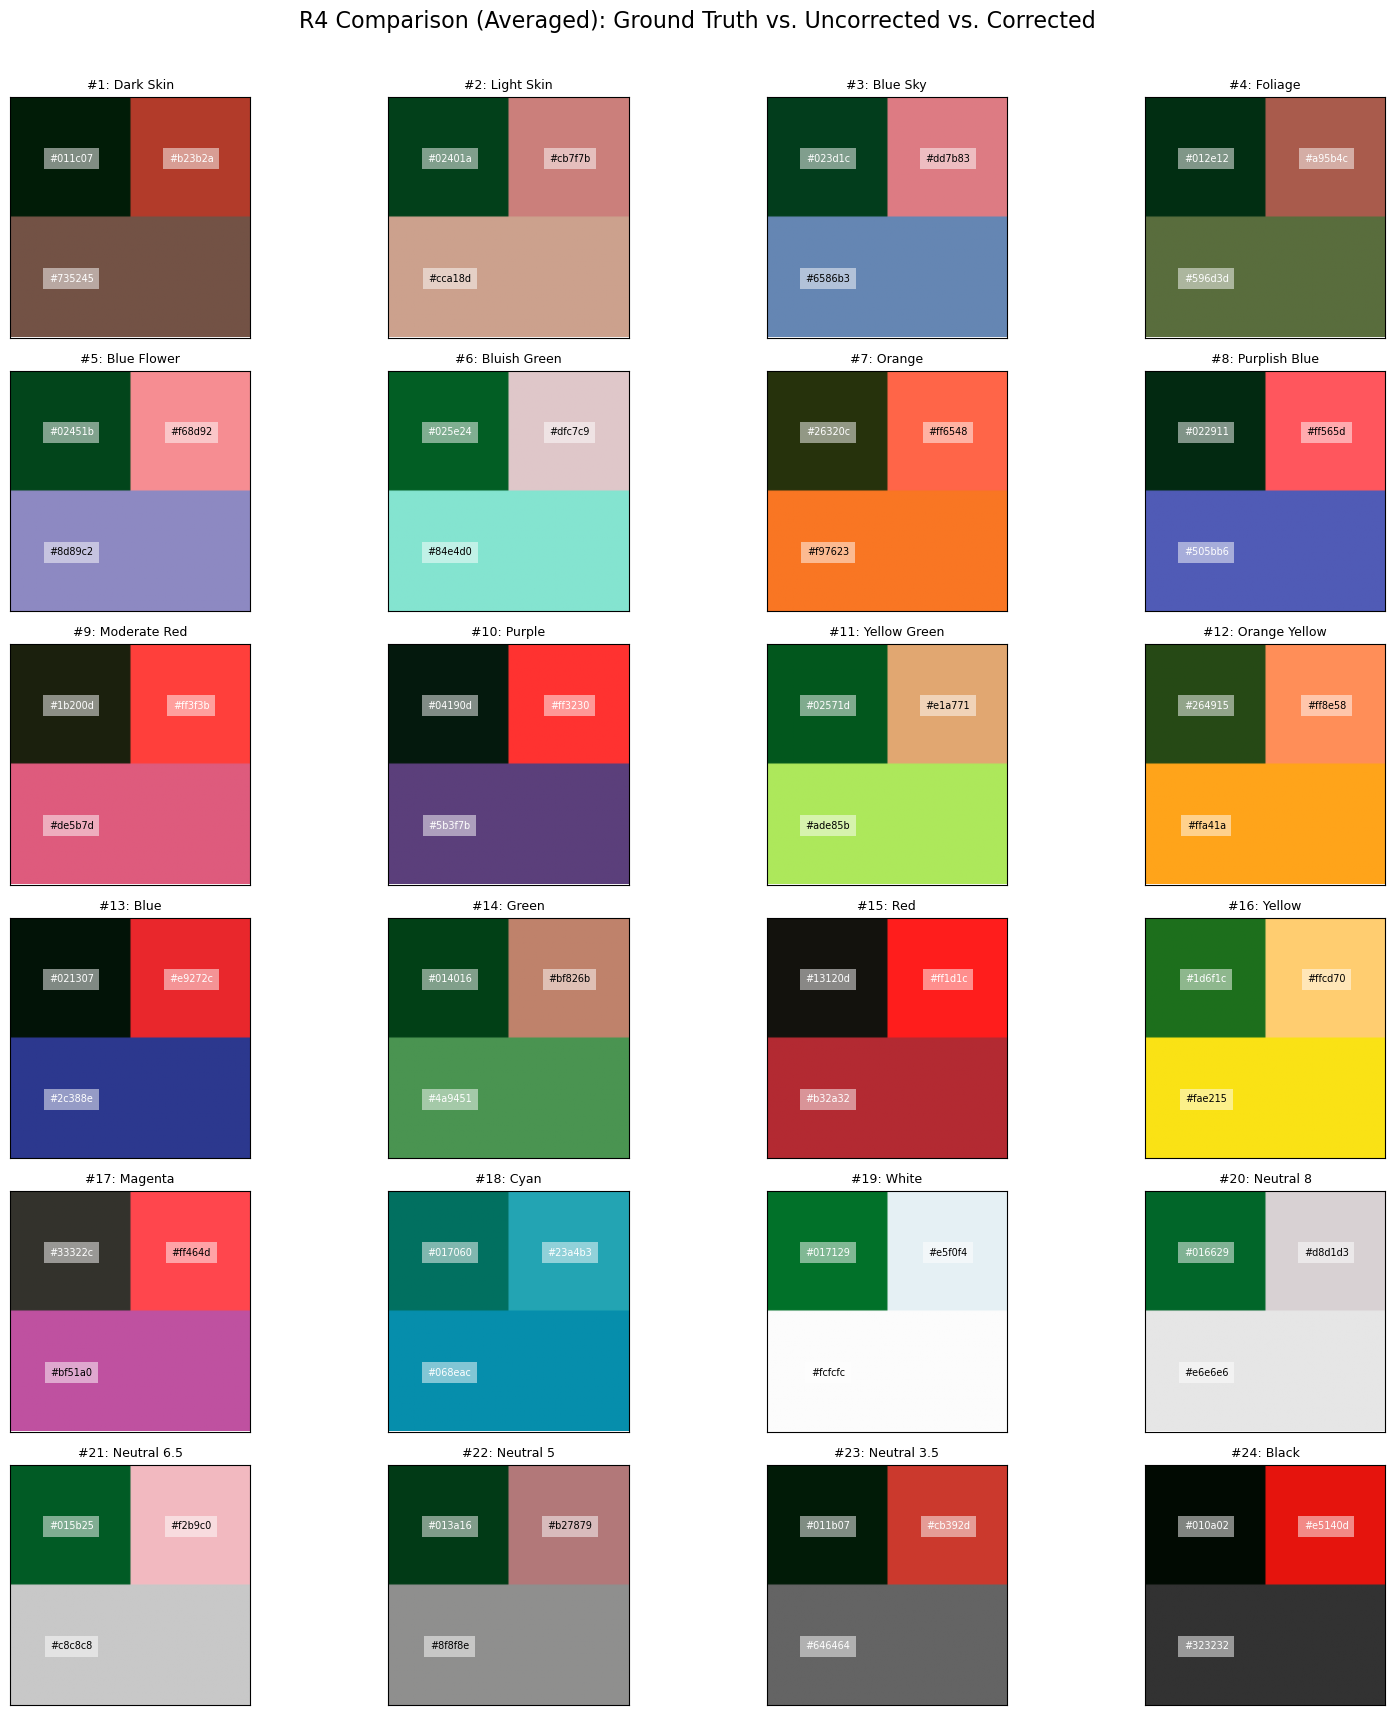

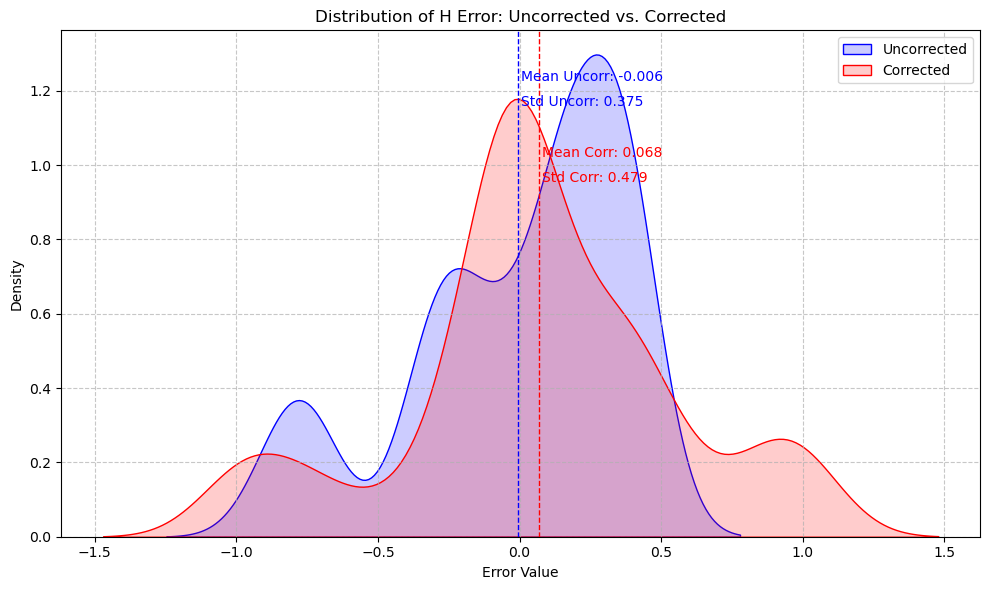

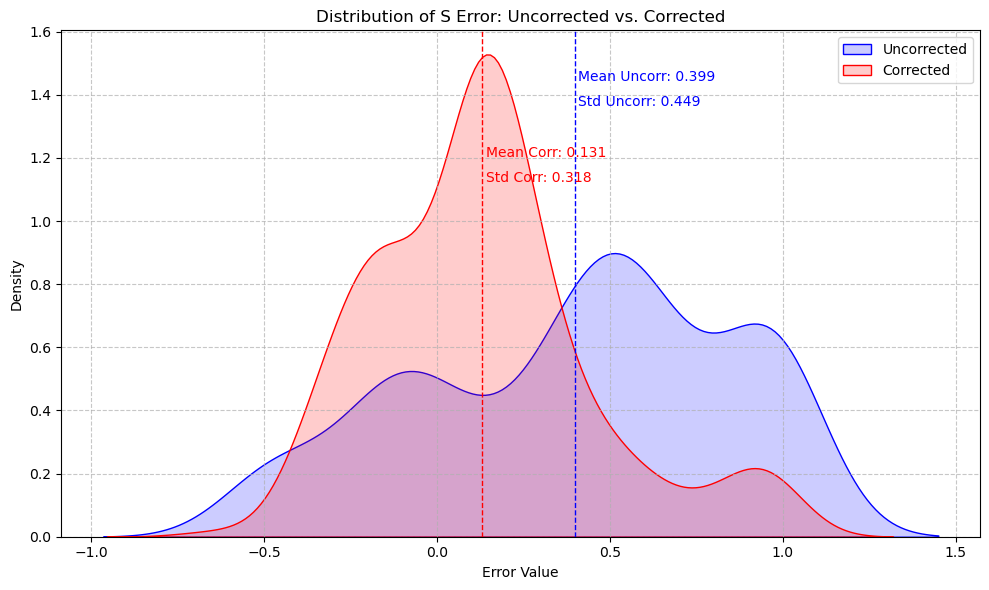

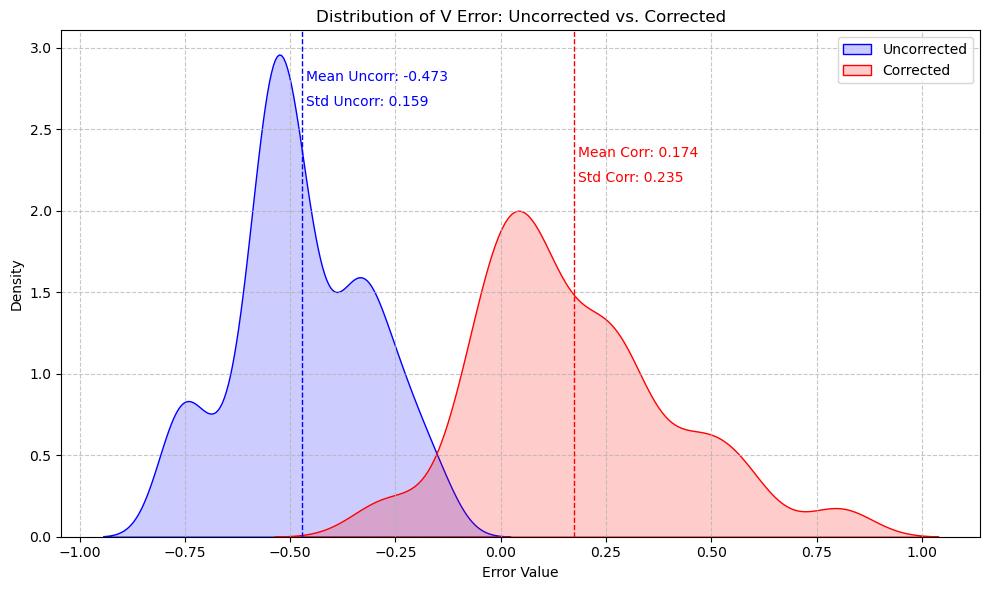

In [12]:
def process_colorimeter_data(input_path, correction_method_name):
    all_dfs = []

    if os.path.isfile(input_path) and input_path.endswith('.json'):
        print(f"Processing single file: {input_path}")
        df_single = pipeline(input_path, correction_method_name=correction_method_name)
        all_dfs.append(df_single)
    elif os.path.isdir(input_path):
        print(f"Processing all JSON files in directory: {input_path}")
        for filename in os.listdir(input_path):
            if filename.endswith('.json'):
                json_file_path = os.path.join(input_path, filename)
                print(f"  Processing: {json_file_path}")
                df_current = pipeline(json_file_path, correction_method_name=correction_method_name)
                all_dfs.append(df_current)
    else:
        print(f"Invalid input path: {input_path}. Please provide a valid JSON file or directory containing JSON files.")
        return pd.DataFrame() # Return an empty DataFrame for invalid input

    if all_dfs:
        combined_df = pd.concat(all_dfs, ignore_index=True)
        return combined_df
    else:
        return pd.DataFrame() # Return empty DataFrame if no files processed


corrected_function = partial(correctByScaling, RefOption = 'white')

# User choice: provide a single file path or a directory path
# Uncomment ONE of the lines below:

# For a single file:
input_data_path = 'Data/ambient_green.json'
# For all files in a directory (make sure the directory exists and contains JSON files):
# input_data_path = '/content/drive/MyDrive/Colorimeter/Data'

df = process_colorimeter_data(input_data_path, correction_method_name=corrected_function)

if not df.empty:
    df = generateFinalDataFrame(df)
    plotAllRadius(df)
    #fig, axs = plot_error_dist(df, r=2)
    df = df_HSV(df)
    plotHSV(df)
else:
    print("No data processed. Please check the input path and file(s).")

✅ JSON file loaded successfully.

--- Session Metadata ---
sessionName         : ambient_green
lightingCondition   : 11
useReflectiveSurface: False
dateTime            : 2025-12-02T22:34:41.738357

✅ Data flattened into DataFrame with 240 rows (Total captures: 24 samples * 10 captures = 240 rows).

--- DataFrame Head (First 5 Rows) ---
    session_name  sample_number  capture_index  lighting_condition  \
0  ambient_green              1              0                  11   
1  ambient_green              1              1                  11   
2  ambient_green              1              2                  11   
3  ambient_green              1              3                  11   
4  ambient_green              1              4                  11   

   reflective_surface     pitch      roll  white_r0_R  white_r0_G  white_r0_B  \
0               False  4.340647  1.544648           1         127          43   
1               False  4.113008  1.418731           3         127          43  

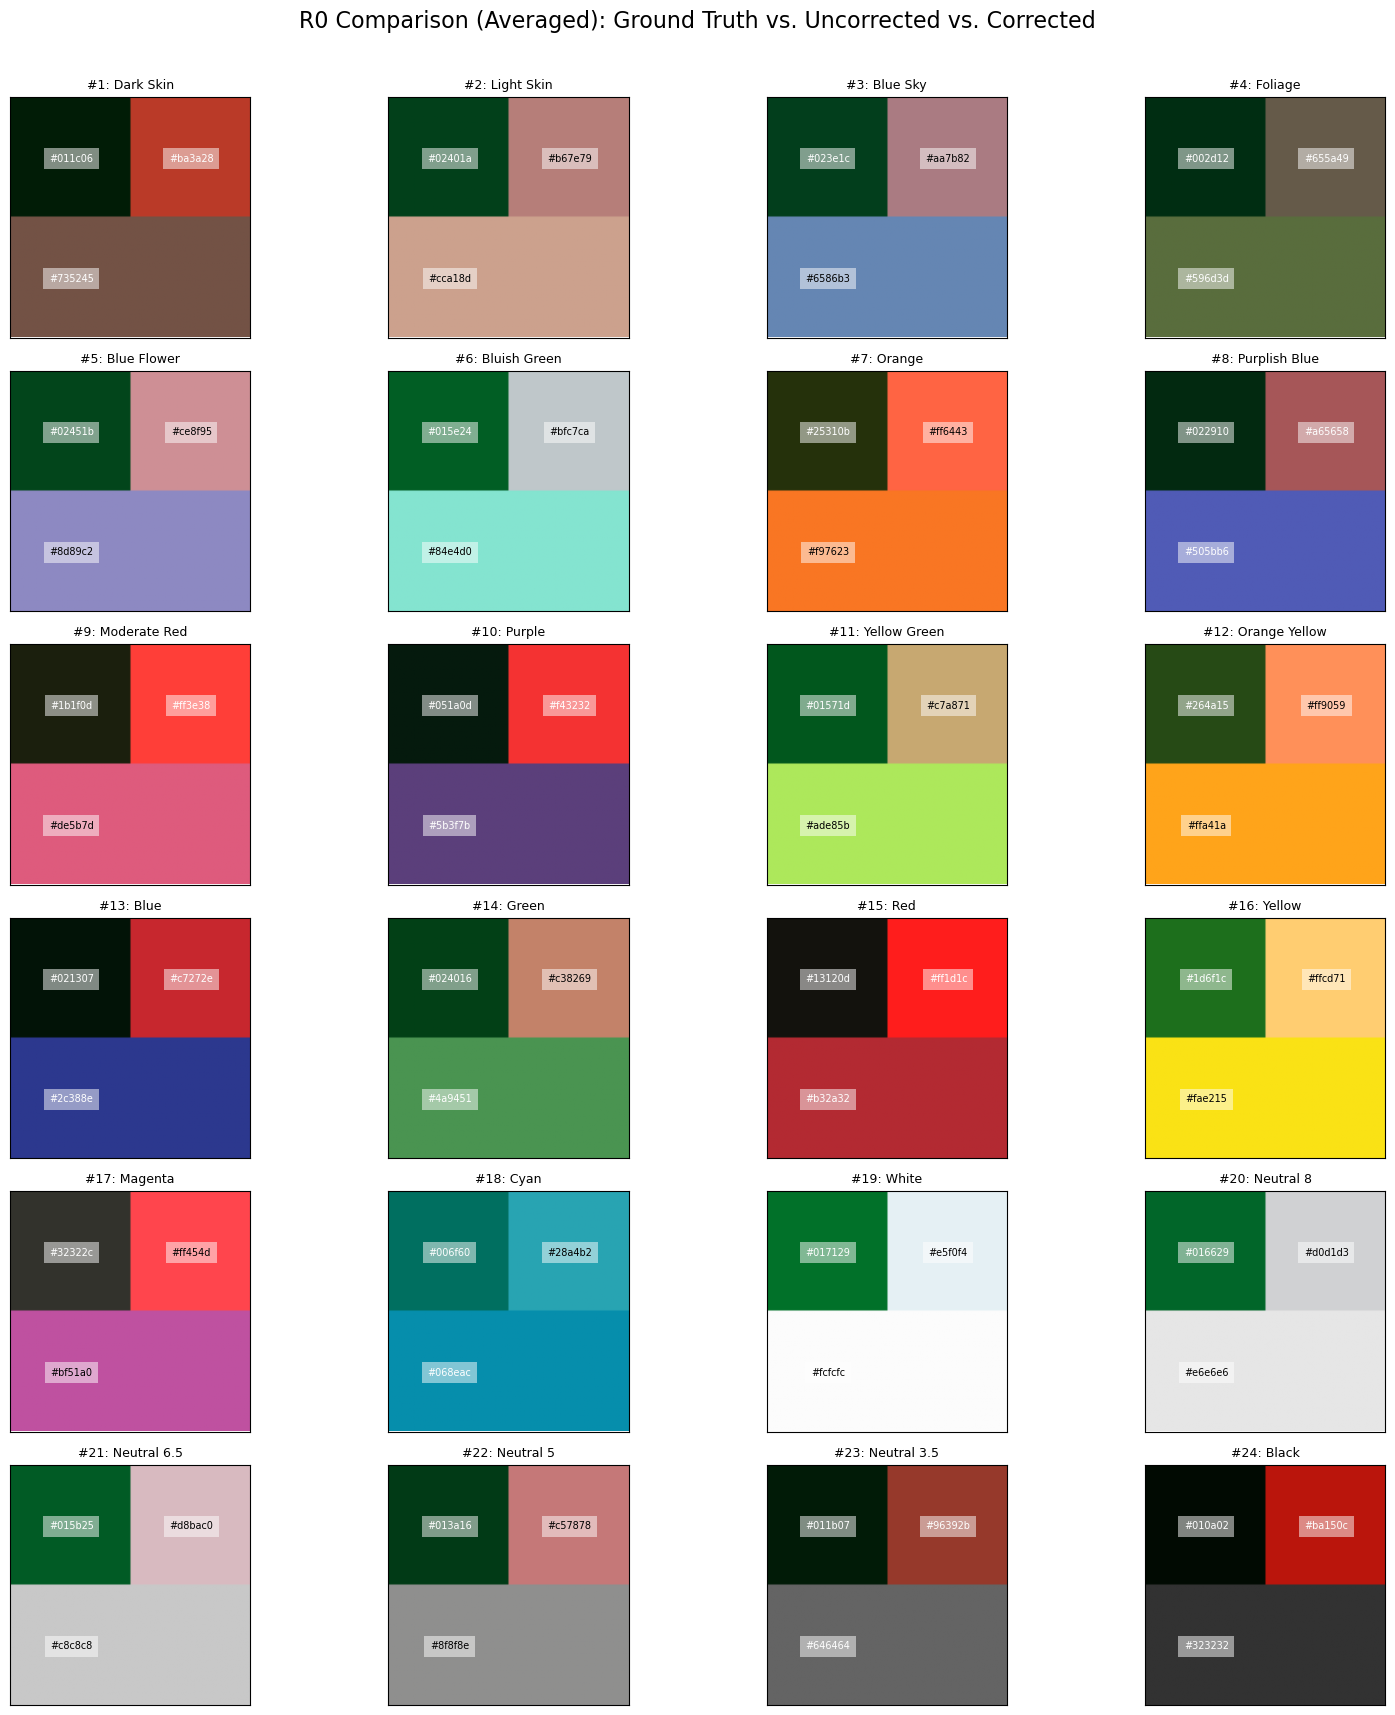

Plotting 24 unique samples for radius r2.


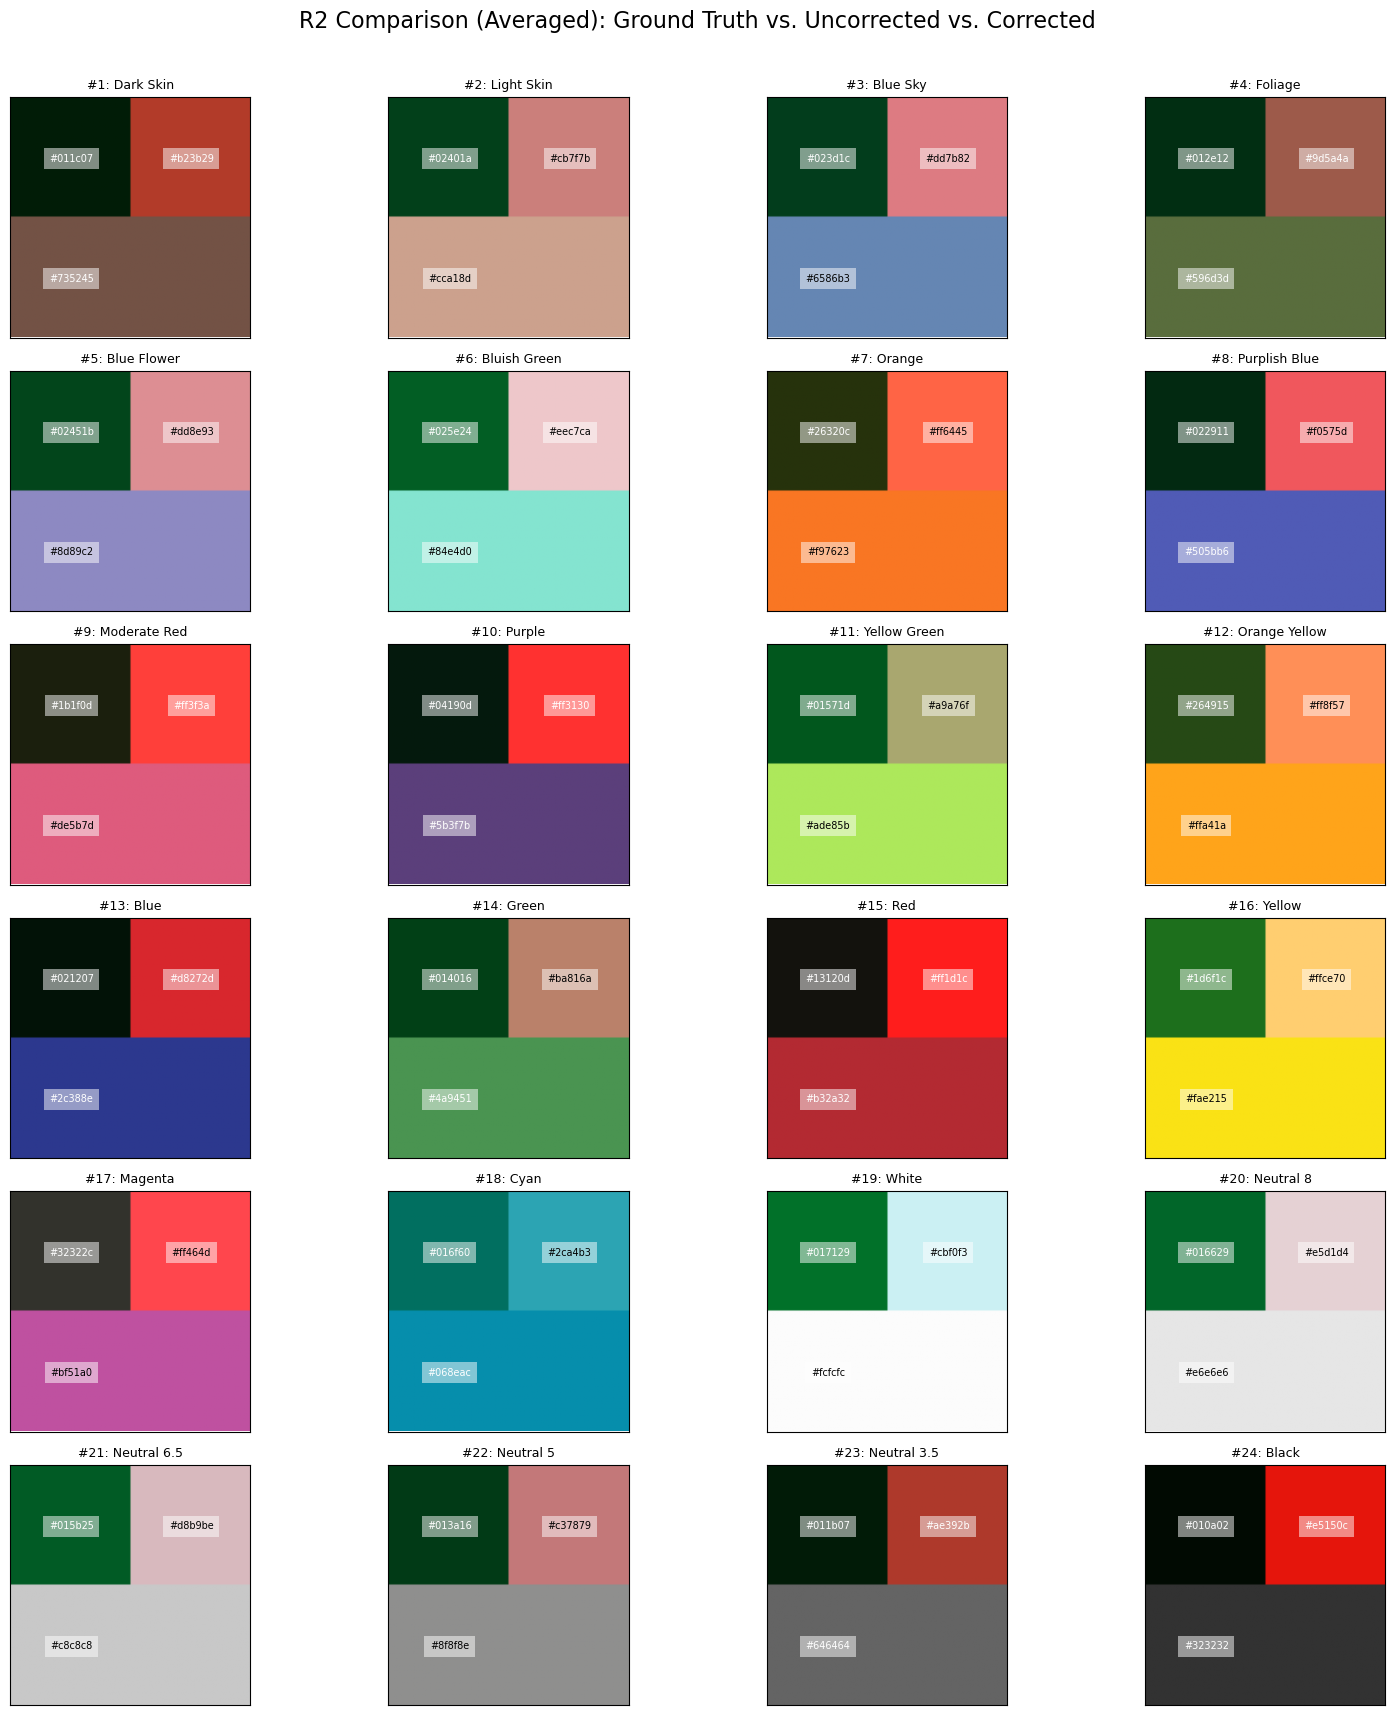

Plotting 24 unique samples for radius r4.


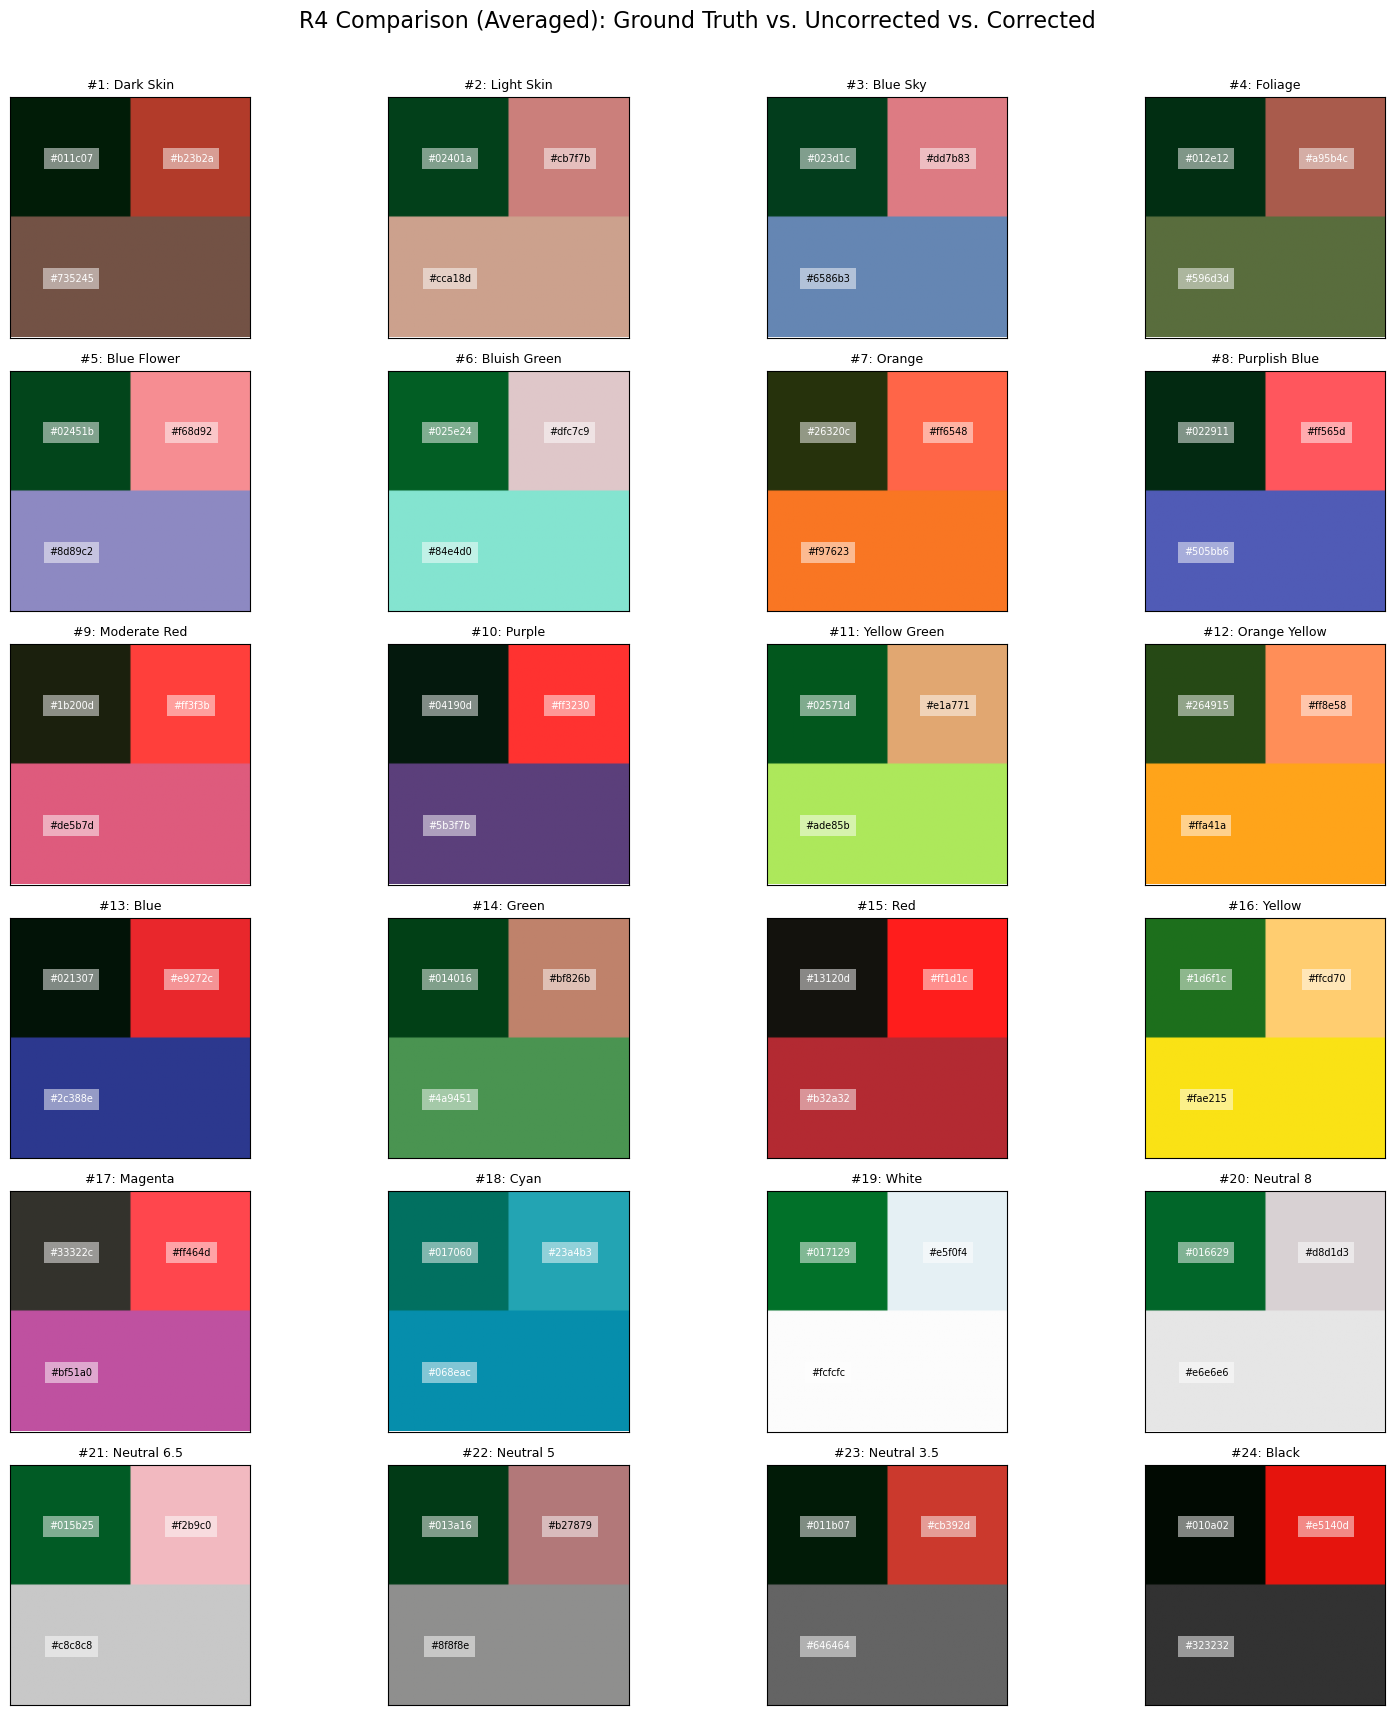

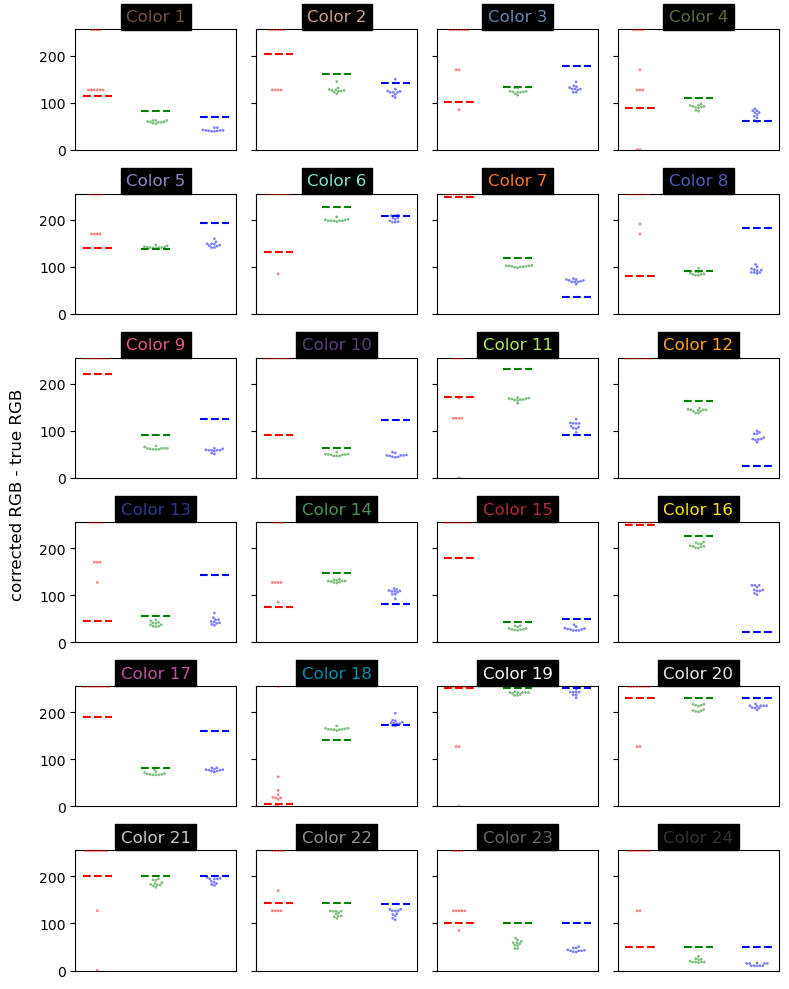

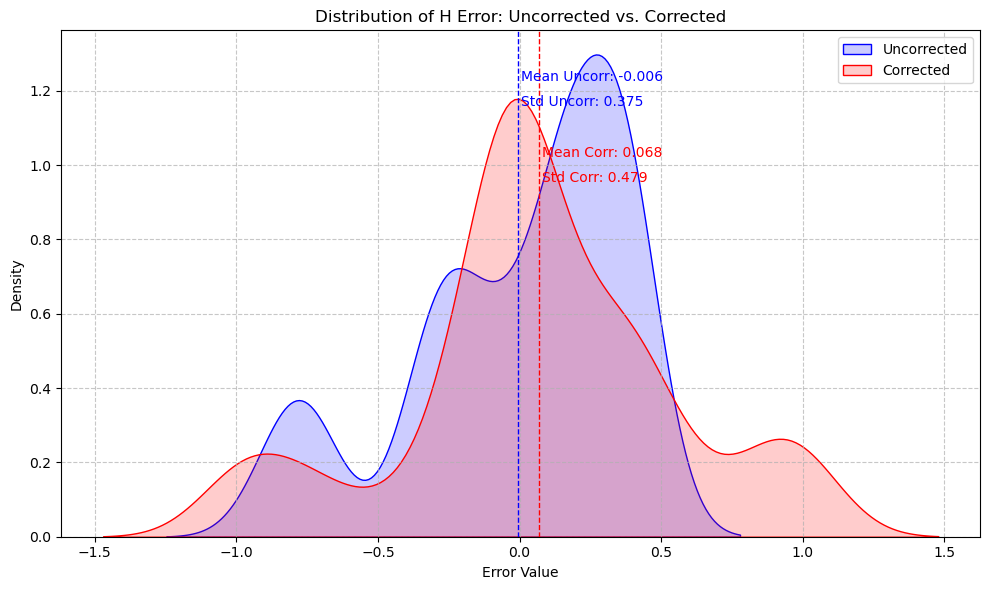

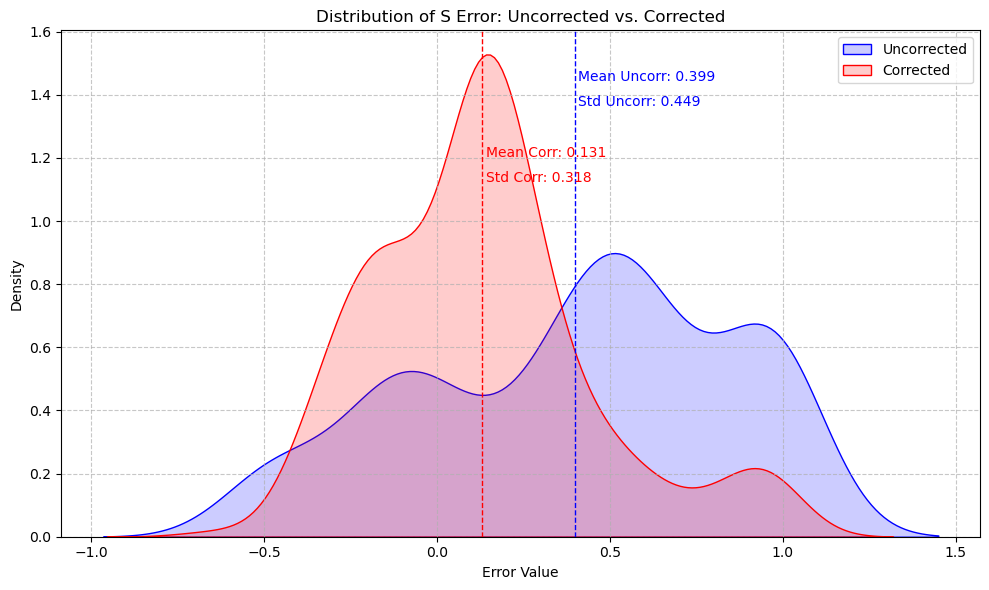

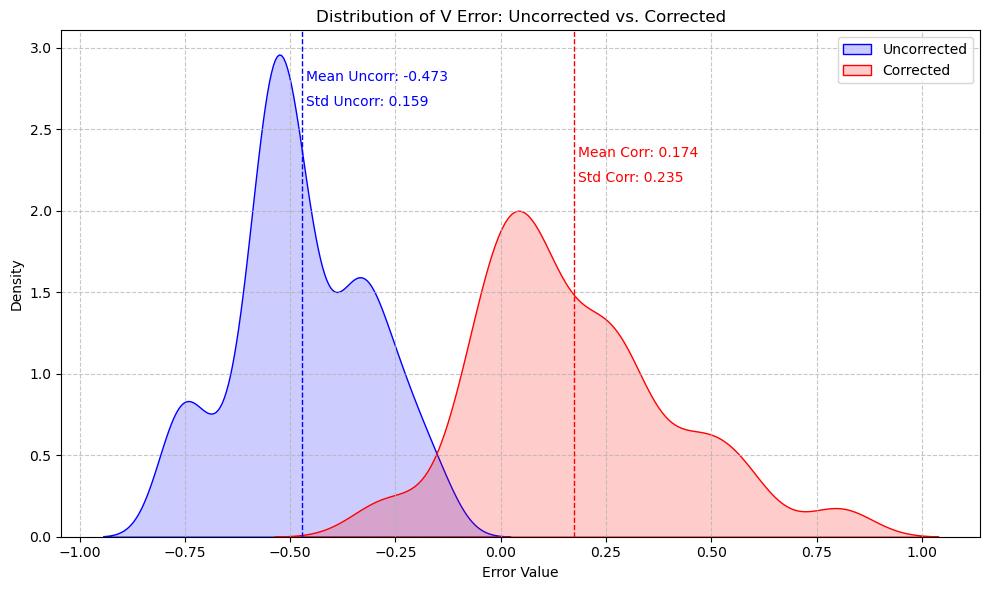

In [13]:
corrected_function = partial(correctByScaling, RefOption='white')
df = pipeline('Data/ambient_green.json', correction_method_name = corrected_function)
df = generateFinalDataFrame(df)
plotAllRadius(df)
fig, axs = plot_error_dist(df, r=2)
df = df_HSV(df)
plotHSV(df)

In [14]:
def findSmallPump(df_final_comparison):
  print("### Data points with Uncorrected H Error between -1.5 and -0.5:")
  uncorr_h_error_filtered = df_final_comparison[(df_final_comparison['H_error_uncorr'] >= -1.5) & (df_final_comparison['H_error_uncorr'] <= -0.5)]
  display(uncorr_h_error_filtered[['sample_number', 'label', 'H_error_uncorr', 'H_error_corr']])

  print("\n### Data points with Corrected H Error between -1.5 and -0.5:")
  corr_h_error_filtered = df_final_comparison[(df_final_comparison['H_error_corr'] >= -1.5) & (df_final_comparison['H_error_corr'] <= -0.5)]
  display(corr_h_error_filtered[['sample_number', 'label', 'H_error_uncorr', 'H_error_corr']])
findSmallPump(df)

### Data points with Uncorrected H Error between -1.5 and -0.5:


sample_number         label  H_error_uncorr  H_error_corr
80               9  Moderate Red       -0.748410     -0.948573
81               9  Moderate Red       -0.754989     -0.950142
82               9  Moderate Red       -0.750861      0.042398
83               9  Moderate Red       -0.743780     -0.954192
84               9  Moderate Red       -0.754989     -0.951692
85               9  Moderate Red       -0.748410     -0.950791
86               9  Moderate Red       -0.750861     -0.956743
87               9  Moderate Red       -0.750861     -0.954179
88               9  Moderate Red       -0.760665     -0.953342
89               9  Moderate Red       -0.754989     -0.949090
140             15           Red       -0.851379      0.008217
141             15           Red       -0.823601     -0.986564
142             15           Red       -0.871220      0.008985
143             15           Red       -0.856934      0.009001
144             15           Red       -0.851379     -0.989543
145             15           Red       -0.856934     -0.990268
146             15           Red       -0.851379     -0.990268
147             15           Red       -0.851379     -0.990268
148             15           Red       -0.795823     -0.988806
149             15           Red       -0.851379     -0.988818
160             17       Magenta       -0.746970      0.112605
161             17       Magenta       -0.746970      0.110736
162             17       Magenta       -0.824747      0.109945
163             17       Magenta       -0.746970      0.114378
164             17       Magenta       -0.780303      0.111676
165             17       Magenta       -0.746970      0.112490
166             17       Magenta       -0.746970      0.111676
167             17       Magenta       -0.713636      0.112330
168             17       Magenta       -0.746970      0.110590
169             17       Magenta       -0.685859     -0.876599


### Data points with Corrected H Error between -1.5 and -0.5:


sample_number         label  H_error_uncorr  H_error_corr
47               5   Blue Flower       -0.283491     -0.678363
49               5   Blue Flower       -0.286948     -0.669591
80               9  Moderate Red       -0.748410     -0.948573
81               9  Moderate Red       -0.754989     -0.950142
83               9  Moderate Red       -0.743780     -0.954192
84               9  Moderate Red       -0.754989     -0.951692
85               9  Moderate Red       -0.748410     -0.950791
86               9  Moderate Red       -0.750861     -0.956743
87               9  Moderate Red       -0.750861     -0.954179
88               9  Moderate Red       -0.760665     -0.953342
89               9  Moderate Red       -0.754989     -0.949090
90              10        Purple       -0.342929     -0.742029
91              10        Purple       -0.344444     -0.742075
92              10        Purple       -0.347619     -0.741270
94              10        Purple       -0.344444     -0.743639
95              10        Purple       -0.344444     -0.742857
97              10        Purple       -0.342929     -0.742029
98              10        Purple       -0.342929     -0.742041
99              10        Purple       -0.342929     -0.744444
129             13          Blue       -0.275888     -0.645483
141             15           Red       -0.823601     -0.986564
144             15           Red       -0.851379     -0.989543
145             15           Red       -0.856934     -0.990268
146             15           Red       -0.851379     -0.990268
147             15           Red       -0.851379     -0.990268
148             15           Red       -0.795823     -0.988806
149             15           Red       -0.851379     -0.988818
169             17       Magenta       -0.685859     -0.876599

In [15]:
def convert_rgb_to_hsv(r, g, b):
    # Normalize RGB values to 0-1 range
    normalized_rgb = np.array([r, g, b]) / 255.0
    # Convert to HSV. rgb_to_hsv expects a single pixel, so we pass a 1D array.
    hsv = rgb_to_hsv(normalized_rgb)
    return hsv[0], hsv[1], hsv[2]

def plotHSVError(option = 'V'):
  # Create a figure with two subplots side-by-side
  fig, axes = plt.subplots(1, 2, figsize=(20, 6)) # 1 row, 2 columns

  # Get the error column name based on the option
  error_col = f'individual_{option}_error_corr'

  # Create a palette mapping labels to their ground truth hex colors
  # Ensure df['gt_hex_color'] is available (created in HSV_error function)
  label_color_map = df[['label', 'gt_hex_color']].drop_duplicates().set_index('label')['gt_hex_color'].to_dict()

  # Plot individual error against pitch on the first subplot
  sns.scatterplot(x='pitch', y=error_col, hue='label', data=df, ax=axes[0],
                  alpha=0.6, s=50, palette=label_color_map, legend='full') # Use custom palette

  # Add regression line
  sns.regplot(x='pitch', y=error_col, data=df, scatter=False, color='red',
              line_kws={'linestyle':'--', 'alpha':0.7, 'lw':2}, ax=axes[0]) # Line color red
  axes[0].set_title(f'Individual Corrected {option} Error vs. Pitch Angle')
  axes[0].set_xlabel('Pitch Angle (degrees)')
  axes[0].set_ylabel(f'Corrected {option} Error (Corrected {option} - Ground Truth {option})')
  axes[0].grid(True, linestyle='--', alpha=0.7)
  # Move legend outside for clarity
  axes[0].legend(title='Sample Label', bbox_to_anchor=(1.05, 1), loc='upper left')

  # Plot individual error against roll on the second subplot
  sns.scatterplot(x='roll', y=error_col, hue='label', data=df, ax=axes[1],
                  alpha=0.6, s=50, palette=label_color_map, legend=False) # Use custom palette, no legend on second plot

  # Add regression line
  sns.regplot(x='roll', y=error_col, data=df, scatter=False, color='red',
              line_kws={'linestyle':'--', 'alpha':0.7, 'lw':2}, ax=axes[1]) # Line color red
  axes[1].set_title(f'Individual Corrected {option} Error vs. Roll Angle')
  axes[1].set_xlabel('Roll Angle (degrees)')
  axes[1].set_ylabel(f'Corrected {option} Error (Corrected {option} - Ground Truth {option})')
  axes[1].grid(True, linestyle='--', alpha=0.7)
  # No legend needed here, as the first subplot has it.

  plt.tight_layout(rect=[0, 0, 0.95, 1]) # Adjust layout to prevent legend overlap
  plt.show()

# Apply to Ground Truth colors in df
def HSV_error(df):
  df[['gt_H_individual', 'gt_S_individual', 'gt_V_individual']] = df.apply(
      lambda row: convert_rgb_to_hsv(row['gt__R'], row['gt__G'], row['gt__B']),
      axis=1,
      result_type='expand'
  )

  # Add gt_hex_color column
  df['gt_hex_color'] = df.apply(lambda row: rgb_to_hex(row['gt__R'], row['gt__G'], row['gt__B']), axis=1)

  # Apply to Corrected colors in df
  df[['corrected_r2_H_individual', 'corrected_r2_S_individual', 'corrected_r2_V_individual']] = df.apply(
      lambda row: convert_rgb_to_hsv(row['correction_r2_R'], row['correction_r2_G'], row['correction_r2_B']),
      axis=1,
      result_type='expand'
  )

  print("### Head of DataFrame with new individual HSV columns:")
  print(df[[
      'sample_number', 'capture_index',
      'gt__R', 'gt__G', 'gt__B', 'gt_H_individual', 'gt_S_individual', 'gt_V_individual',
      'correction_r2_R', 'correction_r2_G', 'correction_r2_B', 'corrected_r2_H_individual', 'corrected_r2_S_individual', 'corrected_r2_V_individual'
  ]].head())

  # Value error
  df['individual_V_error_corr'] = df['corrected_r2_V_individual'] - df['gt_V_individual']

  print("### Head of DataFrame with new individual_V_error_corr column:\n")
  print(df[['sample_number', 'capture_index', 'gt_V_individual', 'corrected_r2_V_individual', 'individual_V_error_corr']].head())

  correlation_pitch_V_error = df['individual_V_error_corr'].corr(df['pitch'])
  correlation_roll_V_error = df['individual_V_error_corr'].corr(df['roll'])

  print(f"Pearson correlation between individual_V_error_corr and pitch: {correlation_pitch_V_error:.4f}")
  print(f"Pearson correlation between individual_V_error_corr and roll: {correlation_roll_V_error:.4f}")
  plotHSVError('V')


  # Hue error
  df['individual_H_error_corr'] = df['corrected_r2_H_individual'] - df['gt_H_individual']

  print("### Head of DataFrame with new individual_H_error_corr column:\n")
  print(df[['sample_number', 'capture_index', 'gt_H_individual', 'corrected_r2_H_individual', 'individual_H_error_corr']].head())

  correlation_pitch_H_error = df['individual_H_error_corr'].corr(df['pitch'])
  correlation_roll_H_error = df['individual_H_error_corr'].corr(df['roll'])

  print(f"Pearson correlation between individual_H_error_corr and pitch: {correlation_pitch_H_error:.4f}")
  print(f"Pearson correlation between individual_H_error_corr and roll: {correlation_roll_H_error:.4f}")
  plotHSVError('H')


  # Saturation error
  df['individual_S_error_corr'] = df['corrected_r2_S_individual'] - df['gt_S_individual']

  print("### Head of DataFrame with new individual_S_error_corr column:\n")
  print(df[['sample_number', 'capture_index', 'gt_S_individual', 'corrected_r2_S_individual', 'individual_S_error_corr']].head())

  correlation_pitch_S_error = df['individual_S_error_corr'].corr(df['pitch'])
  correlation_roll_S_error = df['individual_S_error_corr'].corr(df['roll'])

  print(f"Pearson correlation between individual_S_error_corr and pitch: {correlation_pitch_S_error:.4f}")
  print(f"Pearson correlation between individual_S_error_corr and roll: {correlation_roll_S_error:.4f}")
  plotHSVError('S')

### Head of DataFrame with new individual HSV columns:
   sample_number  capture_index  gt__R  gt__G  gt__B  gt_H_individual  \
0              1              0    115     82     69         0.047101   
1              1              1    115     82     69         0.047101   
2              1              2    115     82     69         0.047101   
3              1              3    115     82     69         0.047101   
4              1              4    115     82     69         0.047101   

   gt_S_individual  gt_V_individual  correction_r2_R  correction_r2_G  \
0              0.4          0.45098              127               58   
1              0.4          0.45098              127               58   
2              0.4          0.45098              127               59   
3              0.4          0.45098              127               59   
4              0.4          0.45098              127               62   

   correction_r2_B  corrected_r2_H_individual  corrected_r2_S_indiv

### Head of DataFrame with new individual_H_error_corr column:

   sample_number  capture_index  gt_H_individual  corrected_r2_H_individual  \
0              1              0         0.047101                   0.034483   
1              1              1         0.047101                   0.032946   
2              1              2         0.047101                   0.036398   
3              1              3         0.047101                   0.034884   
4              1              4         0.047101                   0.031250   

   individual_H_error_corr  
0                -0.012619  
1                -0.014156  
2                -0.010703  
3                -0.012218  
4                -0.015851  
Pearson correlation between individual_H_error_corr and pitch: -0.0461
Pearson correlation between individual_H_error_corr and roll: 0.1037


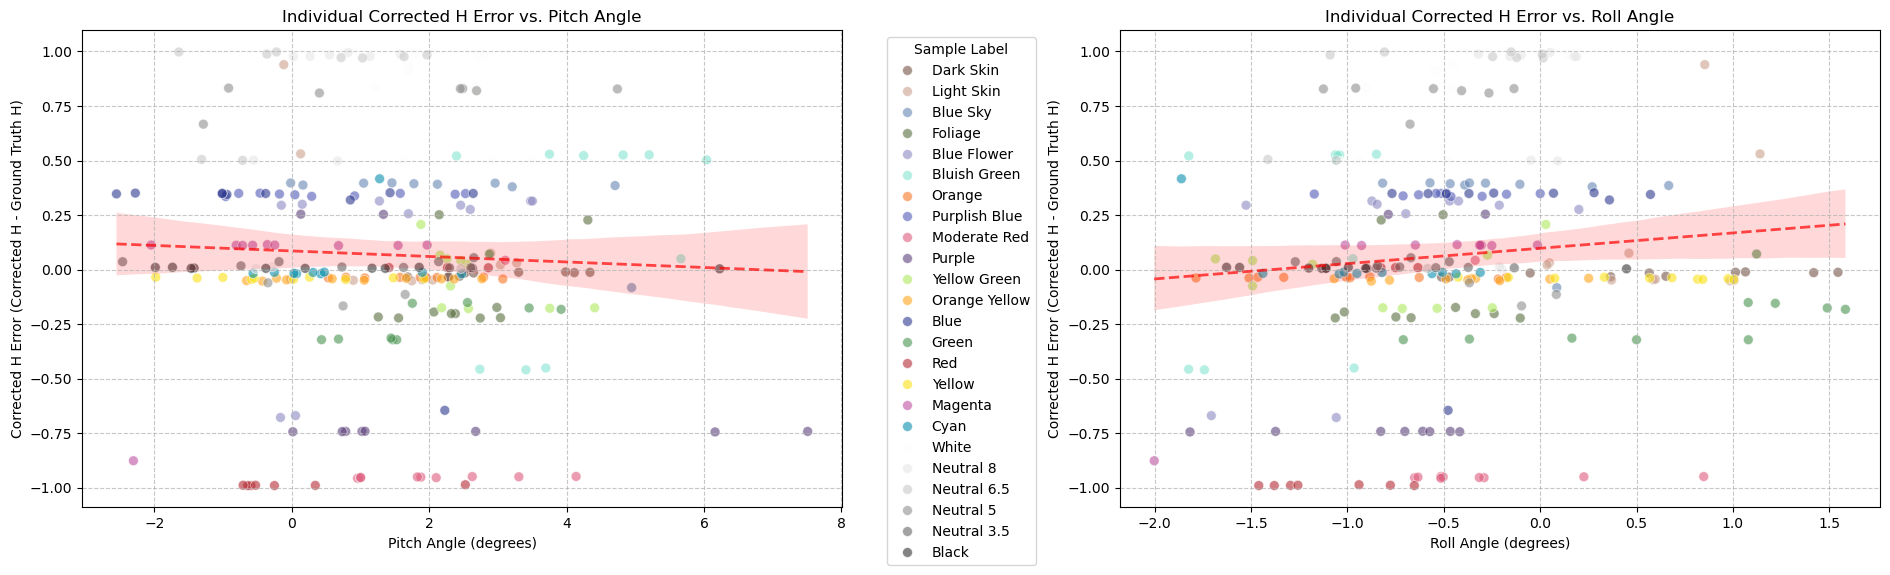

### Head of DataFrame with new individual_S_error_corr column:

   sample_number  capture_index  gt_S_individual  corrected_r2_S_individual  \
0              1              0              0.4                   0.685039   
1              1              1              0.4                   0.677165   
2              1              2              0.4                   0.685039   
3              1              3              0.4                   0.677165   
4              1              4              0.4                   0.629921   

   individual_S_error_corr  
0                 0.285039  
1                 0.277165  
2                 0.285039  
3                 0.277165  
4                 0.229921  
Pearson correlation between individual_S_error_corr and pitch: -0.0829
Pearson correlation between individual_S_error_corr and roll: -0.1668


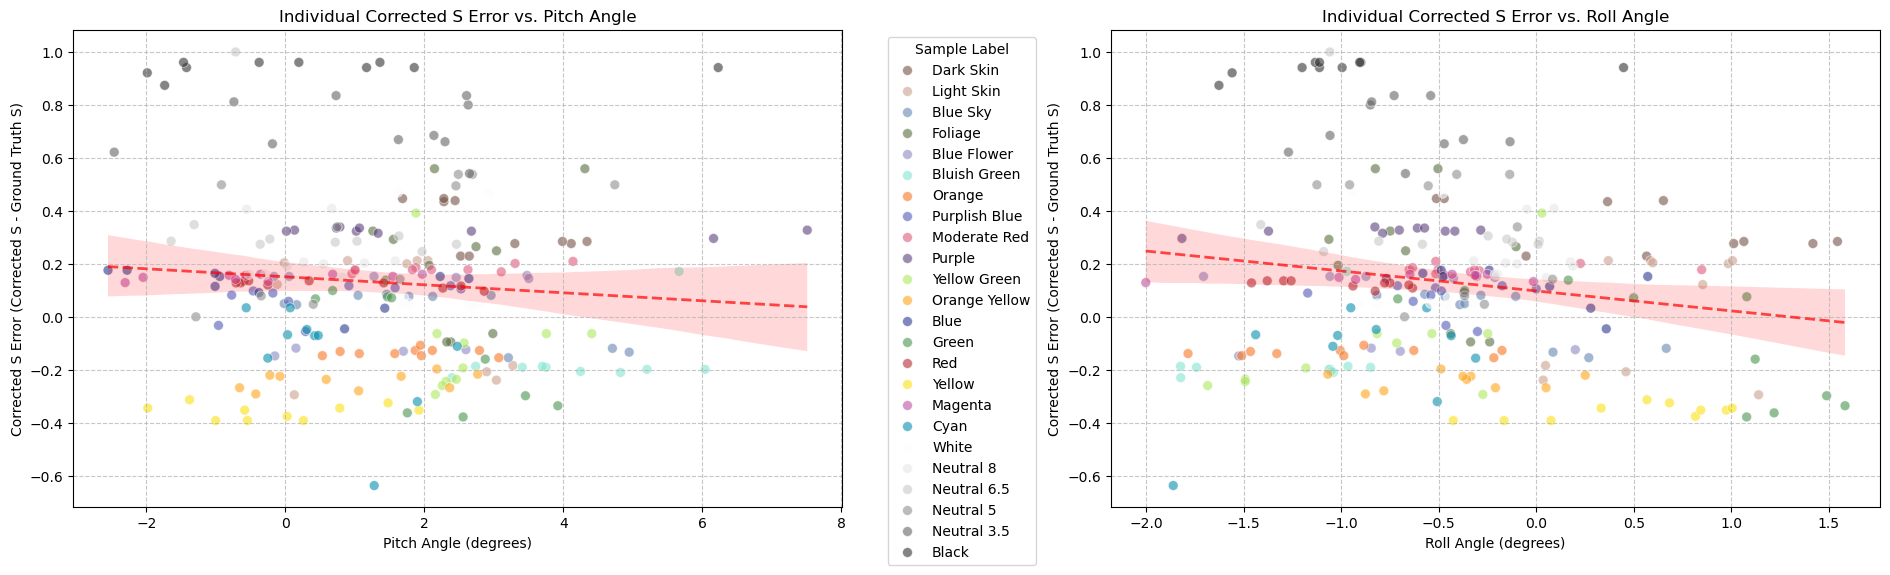

In [16]:
HSV_error(df)

In [17]:
# Perform test
red_samples = df[df['label'] == 'Red']
hue_errors_red = red_samples['individual_H_error_corr']
print("### Extracted 'individual_H_error_corr' for Red samples:")

# Perform one-sample t-test
# H0: mu = 0
# H1: mu < 0 (left-tailed test)

t_statistic, p_value = stats.ttest_1samp(hue_errors_red, 0, alternative='less')

print(f"### One-Sample t-test for 'individual_H_error_corr' in 'Red' samples (against mu=0)\n")
print(f"T-statistic: {t_statistic:.4f}")
print(f"P-value: {p_value:.4e}")

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print(f"\nSince the P-value ({p_value:.4e}) is less than alpha ({alpha}), we reject the null hypothesis.")
    print("Conclusion: The mean 'individual_H_error_corr' for 'Red' samples is significantly less than 0.")
else:
    print(f"\nSince the P-value ({p_value:.4e}) is greater than alpha ({alpha}), we fail to reject the null hypothesis.")
    print("Conclusion: There is no sufficient evidence to conclude that the mean 'individual_H_error_corr' for 'Red' samples is less than 0.")


### Extracted 'individual_H_error_corr' for Red samples:
### One-Sample t-test for 'individual_H_error_corr' in 'Red' samples (against mu=0)

T-statistic: -4.5253
P-value: 7.1795e-04

Since the P-value (7.1795e-04) is less than alpha (0.05), we reject the null hypothesis.
Conclusion: The mean 'individual_H_error_corr' for 'Red' samples is significantly less than 0.


In [18]:
# Perform test
yellowGreen_samples = df[df['label'] == 'Yellow Green']
hue_errors_yG = yellowGreen_samples['individual_S_error_corr']
print("### Extracted 'individual_S_error_corr' for Red samples:")

# Perform one-sample t-test
# H0: mu = 0
# H1: mu < 0 (left-tailed test)

t_statistic, p_value = stats.ttest_1samp(hue_errors_yG, 0, alternative='greater')

print(f"### One-Sample t-test for 'individual_S_error_corr' in 'Red' samples (against mu=0)\n")
print(f"T-statistic: {t_statistic:.4f}")
print(f"P-value: {p_value:.4e}")

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print(f"\nSince the P-value ({p_value:.4e}) is less than alpha ({alpha}), we reject the null hypothesis.")
    print("Conclusion: The mean 'individual_S_error_corr' for 'YGreen' samples is significantly greater than 0.")
else:
    print(f"\nSince the P-value ({p_value:.4e}) is greater than alpha ({alpha}), we fail to reject the null hypothesis.")
    print("Conclusion: There is no sufficient evidence to conclude that the mean 'individual_S_error_corr' for 'YGreen' samples is greater than 0.")


### Extracted 'individual_S_error_corr' for Red samples:
### One-Sample t-test for 'individual_S_error_corr' in 'Red' samples (against mu=0)

T-statistic: -1.7760
P-value: 9.4527e-01

Since the P-value (9.4527e-01) is greater than alpha (0.05), we fail to reject the null hypothesis.
Conclusion: There is no sufficient evidence to conclude that the mean 'individual_S_error_corr' for 'YGreen' samples is greater than 0.


In [19]:
df_final_comparison = generateFinalDataFrame(df)
df_final_comparison_r0 = df_final_comparison[[
    'sample_number', 'label',
    'color_r0_R', 'color_r0_G', 'color_r0_B',
    'correction_r0_R', 'correction_r0_G', 'correction_r0_B',
    'gt__R', 'gt__G', 'gt__B'
]]
df_final_comparison_r0.head()

sample_number      label  color_r0_R  color_r0_G  color_r0_B  \
0              1  Dark Skin           1          29           7   
1              1  Dark Skin           1          29           7   
2              1  Dark Skin           1          29           7   
3              1  Dark Skin           1          29           7   
4              1  Dark Skin           1          30           8   

   correction_r0_R  correction_r0_G  correction_r0_B  gt__R  gt__G  gt__B  
0              255               58               41    115     82     69  
1               85               58               41    115     82     69  
2              127               59               40    115     82     69  
3              127               60               41    115     82     69  
4              127               62               47    115     82     69

In [20]:
def plot_rgb_kde(df, radius_str):
    fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True, sharey=True)
    fig.suptitle(f'RGB Kernel Density Estimation for {radius_str}', fontsize=16)

    color_channels = ['R', 'G', 'B']
    titles = ['Red Channel', 'Green Channel', 'Blue Channel']

    for i, channel in enumerate(color_channels):
        sns.kdeplot(df[f'color_{radius_str}_{channel}'], ax=axes[i], label='Uncorrected', color='red', fill=True, alpha=0.3)
        sns.kdeplot(df[f'correction_{radius_str}_{channel}'], ax=axes[i], label='Corrected', color='green', fill=True, alpha=0.3)
        sns.kdeplot(df[f'gt__{channel}'], ax=axes[i], label='Ground Truth', color='blue', fill=True, alpha=0.3)

        axes[i].set_title(titles[i])
        axes[i].set_xlabel(f'Pixel Value ({channel})')
        axes[i].set_ylabel('Density')
        axes[i].set_xlim(0, 255) # RGB values are typically 0-255
        axes[i].legend()
        axes[i].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

print("KDE plotting function 'plot_rgb_kde' defined.")

KDE plotting function 'plot_rgb_kde' defined.


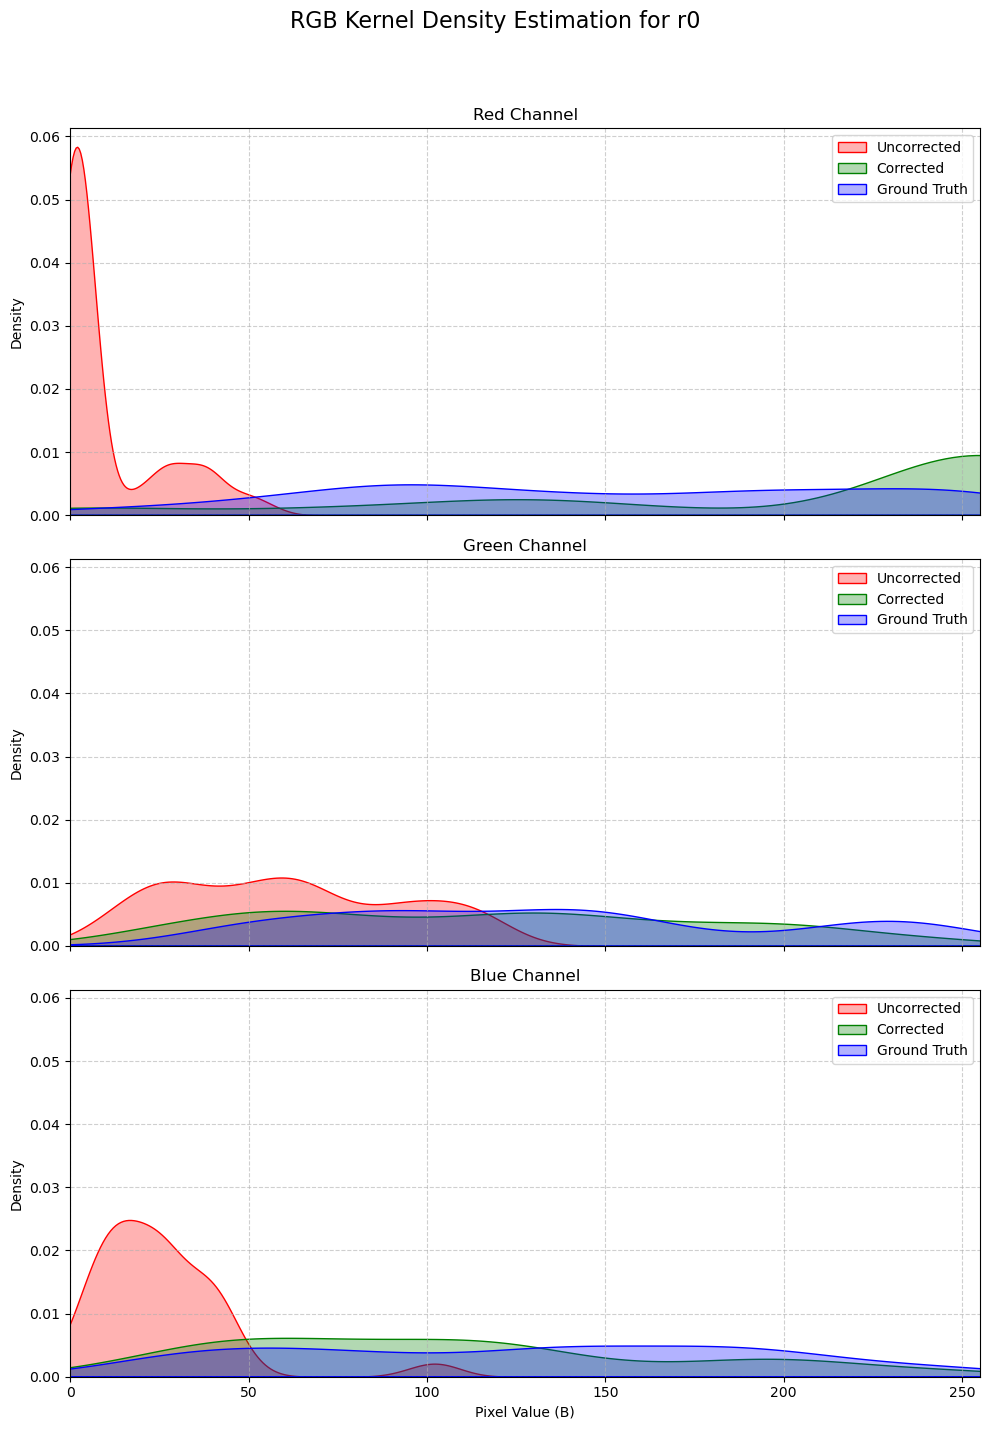

In [21]:
plot_rgb_kde(df_final_comparison_r0, 'r0')

In [22]:
import seaborn as sns # Re-import seaborn to ensure it's available

def plot_rgb_kde(df, radius_str):
    fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True, sharey=True)
    fig.suptitle(f'RGB Kernel Density Estimation for {radius_str}', fontsize=16)

    color_channels = ['R', 'G', 'B']
    titles = ['Red Channel', 'Green Channel', 'Blue Channel']

    for i, channel in enumerate(color_channels):
        sns.kdeplot(df[f'color_{radius_str}_{channel}'], ax=axes[i], label='Uncorrected', color='red', fill=True, alpha=0.3)
        sns.kdeplot(df[f'correction_{radius_str}_{channel}'], ax=axes[i], label='Corrected', color='green', fill=True, alpha=0.3)
        sns.kdeplot(df[f'gt__{channel}'], ax=axes[i], label='Ground Truth', color='blue', fill=True, alpha=0.3)

        axes[i].set_title(titles[i])
        axes[i].set_xlabel(f'Pixel Value ({channel})')
        axes[i].set_ylabel('Density')
        axes[i].set_xlim(0, 255) # RGB values are typically 0-255
        axes[i].legend()
        axes[i].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

print("KDE plotting function 'plot_rgb_kde' defined with seaborn import.")

KDE plotting function 'plot_rgb_kde' defined with seaborn import.


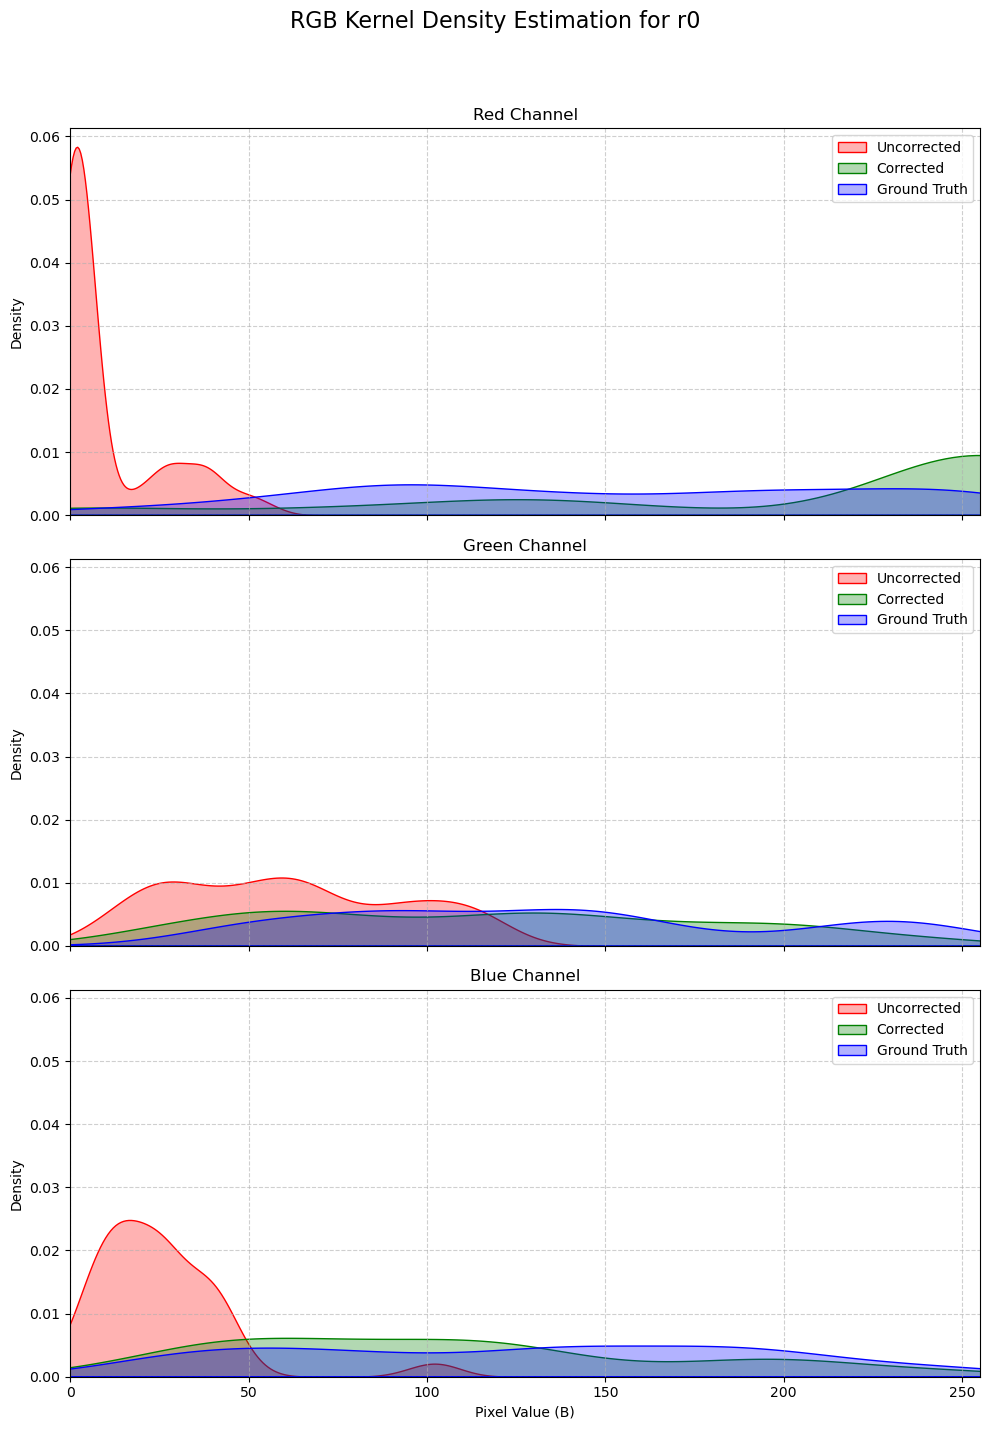

In [23]:
plot_rgb_kde(df_final_comparison_r0, 'r0')

C:\Users\Scenery\AppData\Local\Temp\ipykernel_13836\678193652.py:50: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(gt_data, ax=ax, color=color, linestyle='dotted', fill=False, alpha=0.7)
C:\Users\Scenery\AppData\Local\Temp\ipykernel_13836\678193652.py:50: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(gt_data, ax=ax, color=color, linestyle='dotted', fill=False, alpha=0.7)
C:\Users\Scenery\AppData\Local\Temp\ipykernel_13836\678193652.py:50: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(gt_data, ax=ax, color=color, linestyle='dotted', fill=False, alpha=0.7)
C:\Users\Scenery\AppData\Local\Temp\ipykernel_13836\678193652.py:50: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  

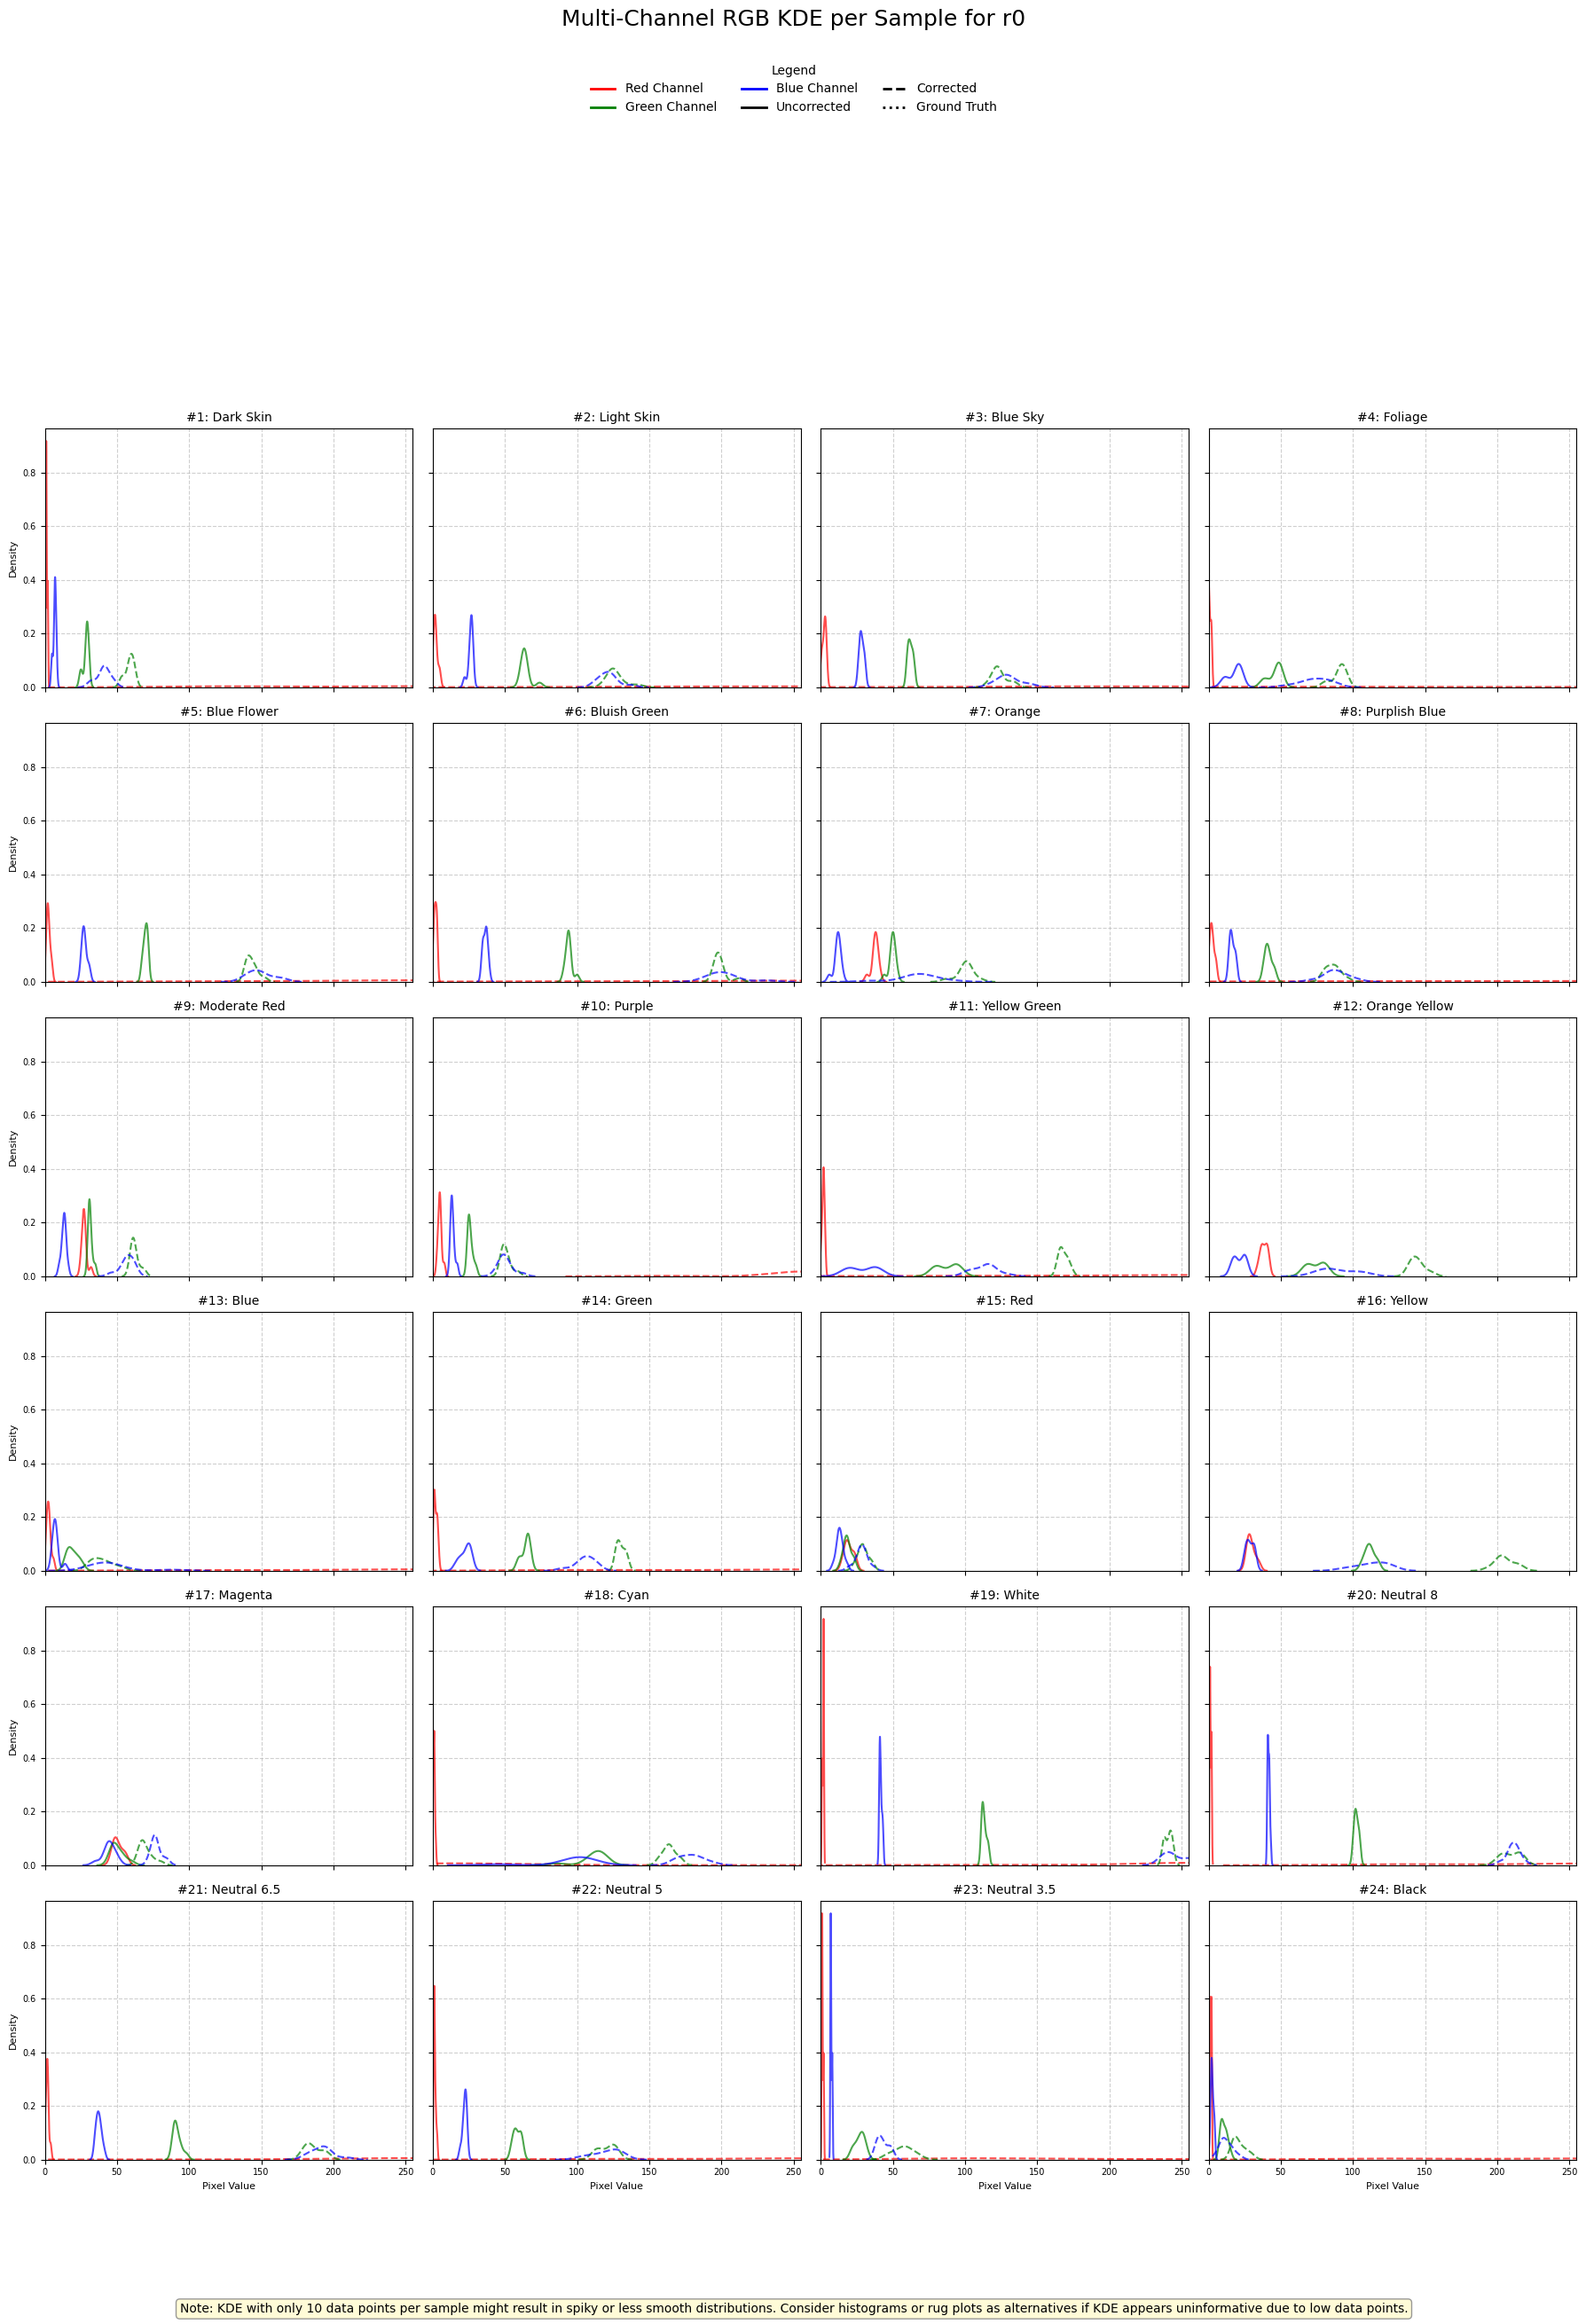

KDE plotting function 'plot_multi_channel_kde_per_sample' defined and executed for r0.


In [24]:
import matplotlib.lines as mlines

def plot_multi_channel_kde_per_sample(df, radius_str):
    num_samples = df['sample_number'].nunique()
    rows = 6
    cols = 4

    if num_samples > rows * cols:
        print(f"Warning: More samples ({num_samples}) than subplots ({rows*cols}). Only the first {rows*cols} will be plotted.")

    fig, axes = plt.subplots(rows, cols, figsize=(20, 25), sharex=True, sharey=True)
    axes = axes.flatten()

    # Get unique sample numbers and labels from the full DataFrame
    unique_samples_info = df[['sample_number', 'label']].drop_duplicates().sort_values('sample_number')

    for i, (sample_num, sample_label) in enumerate(unique_samples_info.values):
        if i >= len(axes): # Ensure we don't go out of bounds if num_samples > rows*cols
            break

        ax = axes[i]
        # Filter the original DataFrame to get all 10 measurements for the current sample
        df_sample = df[df['sample_number'] == sample_num]

        # Extract ground truth values (they are constant per sample)
        gt_r = df_sample['gt__R'].iloc[0]
        gt_g = df_sample['gt__G'].iloc[0]
        gt_b = df_sample['gt__B'].iloc[0]

        # Create Series for ground truth to plot with kdeplot
        gt_r_series = pd.Series([gt_r] * len(df_sample))
        gt_g_series = pd.Series([gt_g] * len(df_sample))
        gt_b_series = pd.Series([gt_b] * len(df_sample))

        channel_colors = {'R': 'red', 'G': 'green', 'B': 'blue'}
        channel_data_map = {
            'R': (df_sample[f'color_{radius_str}_R'], df_sample[f'correction_{radius_str}_R'], gt_r_series),
            'G': (df_sample[f'color_{radius_str}_G'], df_sample[f'correction_{radius_str}_G'], gt_g_series),
            'B': (df_sample[f'color_{radius_str}_B'], df_sample[f'correction_{radius_str}_B'], gt_b_series)
        }

        for channel, color in channel_colors.items():
            uncorr_data, corr_data, gt_data = channel_data_map[channel]

            # Uncorrected (solid line)
            sns.kdeplot(uncorr_data, ax=ax, color=color, linestyle='solid', fill=False, alpha=0.7)
            # Corrected (dashed line)
            sns.kdeplot(corr_data, ax=ax, color=color, linestyle='dashed', fill=False, alpha=0.7)
            # Ground Truth (dotted line)
            sns.kdeplot(gt_data, ax=ax, color=color, linestyle='dotted', fill=False, alpha=0.7)

        ax.set_title(f"#{int(sample_num)}: {sample_label}", fontsize=10)
        ax.set_xlabel('Pixel Value', fontsize=8)
        ax.set_ylabel('Density', fontsize=8)
        ax.set_xlim(0, 255)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.tick_params(axis='both', which='major', labelsize=7)

    # Hide any unused subplots if num_samples is less than rows * cols
    for j in range(num_samples, len(axes)):
        if j < len(axes):
            fig.delaxes(axes[j])

    # Create proxy Line2D objects for the comprehensive legend
    legend_elements = [
        mlines.Line2D([0], [0], color='red', lw=2, label='Red Channel', linestyle='solid'),
        mlines.Line2D([0], [0], color='green', lw=2, label='Green Channel', linestyle='solid'),
        mlines.Line2D([0], [0], color='blue', lw=2, label='Blue Channel', linestyle='solid'),
        mlines.Line2D([0], [0], color='black', lw=2, label='Uncorrected', linestyle='solid'),
        mlines.Line2D([0], [0], color='black', lw=2, label='Corrected', linestyle='dashed'),
        mlines.Line2D([0], [0], color='black', lw=2, label='Ground Truth', linestyle='dotted')
    ]

    # Add the common legend to the entire figure
    fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.02),
               ncol=3, title="Legend", fontsize='medium', frameon=False)

    # Set main title
    fig.suptitle(f'Multi-Channel RGB KDE per Sample for {radius_str}', fontsize=18, y=1.04)

    # Add explanatory text note
    fig.text(0.5, 0.00,
             'Note: KDE with only 10 data points per sample might result in spiky or less smooth distributions. '
             'Consider histograms or rug plots as alternatives if KDE appears uninformative due to low data points.',
             ha='center', va='bottom', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="lemonchiffon", ec="gray", lw=1, alpha=0.8))

    # Adjust subplot parameters for a tight layout, leaving space for title, legend, and text
    plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.88])

    plt.show()

# Call the function with the main DataFrame 'df' (from the pipeline output) and 'r0'
plot_multi_channel_kde_per_sample(df, 'r0')

print("KDE plotting function 'plot_multi_channel_kde_per_sample' defined and executed for r0.")

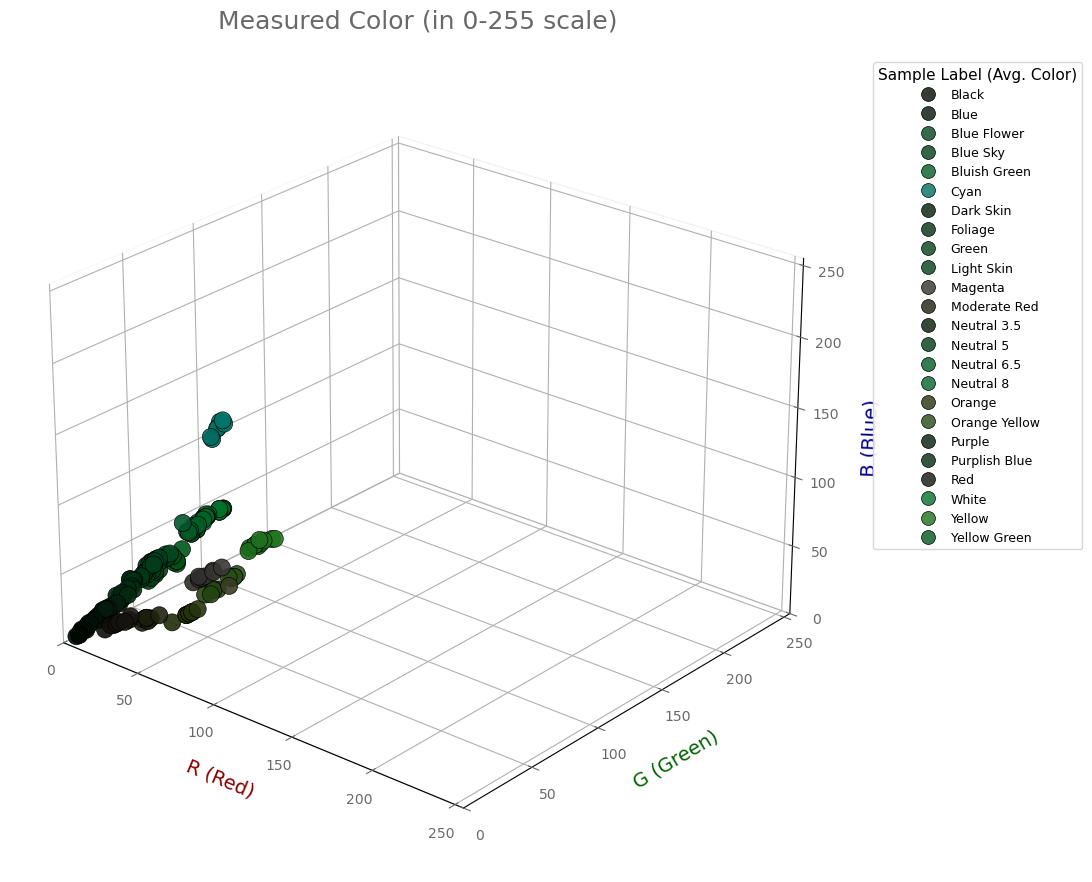

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import to_rgba # For better color handling

# Use the actual column names from your plot
R_COL, G_COL, B_COL = 'color_r0_R', 'color_r0_G', 'color_r0_B'

# 1. Setup the figure and 3D axis with a darker background for contrast
fig = plt.figure(figsize=(12, 10), facecolor='white') # Lighter background for the figure
ax = fig.add_subplot(projection='3d')

# Set subplot background for 3D plot
ax.set_facecolor('white') # A subtle gray can look more sophisticated
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.edgecolor = 'white'
ax.yaxis.pane.edgecolor = 'white'
ax.zaxis.pane.edgecolor = 'white'

# --- Modifications start here ---

# Prepare colors for each point based on its own RGB values
# Normalize to 0-1 range for matplotlib
point_colors_normalized = df[[R_COL, G_COL, B_COL]].values / 255.0

# Calculate average colors for each label for the legend
avg_colors_for_legend = df.groupby('label')[[R_COL, G_COL, B_COL]].mean().reset_index()
# Sort to ensure legend order matches unique_labels for consistency
avg_colors_for_legend = avg_colors_for_legend.sort_values('label')

# Map average RGB to normalized RGBA for legend handles
avg_colors_for_legend['rgba'] = avg_colors_for_legend[[R_COL, G_COL, B_COL]].apply(
    lambda row: to_rgba((row[R_COL]/255, row[G_COL]/255, row[B_COL]/255), alpha=0.8), axis=1
)

# 3. Plot the data using the 3D ax.scatter method
scatter = ax.scatter(
    xs=df[R_COL],
    ys=df[G_COL],
    zs=df[B_COL],
    c=point_colors_normalized, # Use the actual measured colors for points
    s=150,             # Slightly larger size for better visibility
    edgecolors='black', # Add a thin black border for definition
    linewidths=0.5,     # Thin border
    alpha=0.9,          # Adjust alpha here
    marker='o',
    depthshade=True     # Add shading to give a sense of depth
)

# 4. Set labels and title
ax.set_title('Measured Color (in 0-255 scale)', fontsize=18, color='dimgray', pad=20) # Title style
ax.set_xlabel('R (Red)', fontsize=14, color='darkred', labelpad=10) # X-axis label style
ax.set_ylabel('G (Green)', fontsize=14, color='darkgreen', labelpad=10) # Y-axis label style
ax.set_zlabel('B (Blue)', fontsize=14, color='darkblue', labelpad=10) # Z-axis label style

# Set tick parameters
ax.tick_params(axis='x', labelsize=10, colors='dimgray')
ax.tick_params(axis='y', labelsize=10, colors='dimgray')
ax.tick_params(axis='z', labelsize=10, colors='dimgray')

# 5. Create a legend using the average colors for each label
unique_labels_sorted = avg_colors_for_legend['label'].tolist()
legend_handles = [
    plt.Line2D([0], [0], marker='o', color=avg_colors_for_legend.loc[avg_colors_for_legend['label'] == label, 'rgba'].iloc[0],
               linestyle='', ms=10, label=label, markeredgecolor='black', markeredgewidth=0.5)
    for label in unique_labels_sorted
]

ax.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1),
          loc='upper left', title='Sample Label (Avg. Color)', fontsize=9, title_fontsize=11,
          facecolor='white', edgecolor='lightgray', framealpha=0.9)


# 6. Adjust View and Limits
ax.view_init(elev=25, azim=-50) # New default view angle for better spread and less overlap
# Set explicit limits to fill the space better, or to match 0-255 cube
ax.set_xlim(0, 255)
ax.set_ylim(0, 255)
ax.set_zlim(0, 255)

# Optional: Adjust aspect ratio for a true cube representation
# ax.set_box_aspect([1,1,1]) # Not directly supported by older matplotlib, calculate manually

# 7. Add Grid (Optional, can be removed for cleaner look if preferred)
ax.grid(True, linestyle=':', alpha=0.5, color='gray')


plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to prevent legend overlap
plt.show()